<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Complete Integration: Phase 1 + Phase 2 + Phase 3
Credit Risk Prediction - Final Implementation
"""

import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import tensorflow as tf
import warnings
import os

warnings.filterwarnings('ignore')

# Create results directory
os.makedirs('./results', exist_ok=True)

print("="*80)
print("CREDIT RISK PREDICTION - COMPLETE IMPLEMENTATION")
print("Phase 1: Data Balancing | Phase 2: Cross-Validation | Phase 3: Enhanced Metrics")
print("="*80 + "\n")

CREDIT RISK PREDICTION - COMPLETE IMPLEMENTATION
Phase 1: Data Balancing | Phase 2: Cross-Validation | Phase 3: Enhanced Metrics



# STEP 1: DATA LOADING AND PREPROCESSING

In [3]:
def create_binary_target(df, positive_class):
    """
    Creates a binary target variable from 'loan_status'.

    Args:
        df (pd.DataFrame): The input DataFrame with 'loan_status'.
        positive_class (str): The value in 'loan_status' to be considered the positive class (1).

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The DataFrame with the new 'loan_status_binary' column.
            - dict: A dictionary mapping original loan status values to their binary encoding.
    """
    df_clean = df.copy()
    # Map the loan status to a binary target
    # 1 for the positive class, 0 for others
    df_clean['loan_status_binary'] = df_clean['loan_status'].apply(
        lambda x: 1 if x == positive_class else 0
    )

    # Create encoding info
    unique_statuses = df_clean['loan_status'].unique()
    encoding_info = {status: (1 if status == positive_class else 0) for status in unique_statuses}

    return df_clean, encoding_info

In [4]:
# Download dataset
dataset_path = kagglehub.dataset_download('jeandedieunyandwi/lending-club-dataset')
file_path = f"{dataset_path}/lending_club_loan_two.csv"
df = pd.read_csv(file_path)

print(f"  Dataset shape: {df.shape}")

# PHASE 1: Create binary target
df_clean, encoding_info = create_binary_target(df, positive_class='Charged Off')

# Sample and preprocess (same as before)
SAMPLE_SIZE = 60000
X_clean = df_clean.drop(['loan_status', 'loan_status_binary'], axis=1)
y_clean = df_clean['loan_status_binary']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

if len(X_train_full) > SAMPLE_SIZE:
    train_indices = X_train_full.sample(n=SAMPLE_SIZE, random_state=42).index
    df_sampled = df_clean.loc[train_indices].copy()
else:
    df_sampled = df_clean.loc[X_train_full.index].copy()

X_sampled = df_sampled.drop(['loan_status', 'loan_status_binary'], axis=1)
y_sampled = df_sampled['loan_status_binary']

# Feature engineering
FEATURE_COLUMNS = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
    'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'annual_inc', 'application_type'
]

available_cols = [col for col in FEATURE_COLUMNS if col in X_sampled.columns]

# Clean string columns
if 'term' in X_sampled.columns and X_sampled['term'].dtype == 'object':
    X_sampled['term'] = X_sampled['term'].str.replace(' months', '', regex=False).astype(float)
if 'int_rate' in X_sampled.columns and X_sampled['int_rate'].dtype == 'object':
    X_sampled['int_rate'] = X_sampled['int_rate'].str.replace('%', '', regex=False).astype(float)
if 'emp_length' in X_sampled.columns and X_sampled['emp_length'].dtype == 'object':
    X_sampled['emp_length'] = X_sampled['emp_length'].replace({
        '< 1 year': '0', '1 year': '1', '2 years': '2', '3 years': '3', '4 years': '4',
        '5 years': '5', '6 years': '6', '7 years': '7', '8 years': '8', '9 years': '9',
        '10+ years': '10', 'n/a': np.nan
    }).astype(float)

# Select features and one-hot encode
final_features = [col for col in available_cols if X_sampled[col].dtype in ['float64', 'int64']]
categorical_features = ['grade', 'application_type']
final_features.extend([c for c in categorical_features if c in X_sampled.columns])

X_final = X_sampled[final_features].copy()
y_final = y_sampled.copy()

combined_df = pd.concat([X_final, y_final], axis=1)
combined_df.dropna(inplace=True)

X_final = combined_df.drop('loan_status_binary', axis=1)
y_final = combined_df['loan_status_binary']

X_encoded = pd.get_dummies(X_final, columns=[c for c in categorical_features if c in X_final.columns], drop_first=True)
X = X_encoded.copy()
y = y_final.copy()

print(f"  Final data: {X.shape[0]} samples, {X.shape[1]} features")
# print("  ✓ Data preprocessing complete\n")

Using Colab cache for faster access to the 'lending-club-dataset' dataset.
  Dataset shape: (396030, 27)
  Final data: 57265 samples, 14 features


# STEP 2: SELECT BEST STRATEGY (or test multiple)

In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

def prepare_data_with_balancing(X, y, strategy='downsample_upsample', ratio=None, random_state=None):
    """
    Applies different balancing strategies to the dataset.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target Series.
        strategy (str): Balancing strategy ('downsample_upsample', 'ratio_based').
        ratio (tuple, optional): Desired ratio of minority to majority class after balancing
                                  if strategy is 'ratio_based'. Defaults to None.
        random_state (int, optional): Random state for reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: Balanced feature DataFrame.
            - pd.Series: Balanced target Series.
            - dict: Information about the balancing applied.
    """
    X_resampled, y_resampled = X.copy(), y.copy()
    balance_info = {"strategy_applied": strategy}

    if strategy == 'downsample_upsample':
        # Separate majority and minority classes
        majority_class = y_resampled.value_counts().idxmax()
        minority_class = y_resampled.value_counts().idxmin()

        # Downsample majority class
        rus = RandomUnderSampler(sampling_strategy={majority_class: y_resampled.value_counts()[minority_class]}, random_state=random_state)
        X_downsampled, y_downsampled = rus.fit_resample(X_resampled, y_resampled)

        # Upsample minority class to match downsampled majority size (which is minority count)
        ros = RandomOverSampler(sampling_strategy={minority_class: len(y_downsampled[y_downsampled == majority_class])}, random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X_downsampled, y_downsampled)

        # Shuffle the combined data
        combined_df = pd.concat([X_resampled, y_resampled], axis=1)
        combined_df = combined_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        X_resampled = combined_df.drop(y_resampled.name, axis=1)
        y_resampled = combined_df[y_resampled.name]

        balance_info['original_counts'] = y.value_counts().to_dict()
        balance_info['resampled_counts'] = y_resampled.value_counts().to_dict()

    elif strategy == 'ratio_based' and ratio is not None:
        # Assuming ratio is (minority, majority) e.g., (0.6, 0.4) for 60% minority
        # This strategy would typically involve SMOTE or similar, but for simplicity,
        # let's assume it defines target sizes based on the original minority count
        # target_minority = original_minority_count * (ratio[0] / original_minority_ratio)
        # target_majority = target_minority * (ratio[1] / ratio[0])

        # A simpler interpretation for demonstration: SMOTE the minority class to a certain ratio
        # Note: This requires defining which class is minority/majority based on original data
        from imblearn.over_sampling import SMOTE

        original_counts = y.value_counts()
        minority_class = original_counts.idxmin()
        majority_class = original_counts.idxmax()
        minority_count = original_counts[minority_class]
        majority_count = original_counts[majority_class]

        # Target number of minority samples after oversampling
        target_minority_count = int(majority_count * (ratio[0] / ratio[1]))

        if target_minority_count <= minority_count:
             print(f"Warning: Target minority count ({target_minority_count}) is less than or equal to original minority count ({minority_count}). No oversampling applied.")
             X_resampled, y_resampled = X.copy(), y.copy() # No change
             balance_info['note'] = 'No oversampling as target ratio is not higher than original'
        else:
            sampling_strategy = {minority_class: target_minority_count, majority_class: majority_count}
            smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            balance_info['original_counts'] = original_counts.to_dict()
            balance_info['resampled_counts'] = y_resampled.value_counts().to_dict()

    else:
        print(f"Warning: Unknown strategy '{strategy}' or missing ratio for 'ratio_based'. No balancing applied.")
        balance_info['note'] = 'No balancing applied due to invalid strategy or ratio'


    return X_resampled, y_resampled, balance_info

In [9]:
# For this demo, we'll use the best strategy from Phase 1+2
# In practice, you'd run all strategies and pick the best one
BEST_STRATEGY = 'downsample_upsample'  # Or '60-40', '70-30', etc.
BEST_RATIO = None  # (0.6, 0.4) if using ratio_based

print(f"  Using strategy: {BEST_STRATEGY}")

# PHASE 1: Apply balancing
X_balanced, y_balanced, balance_info = prepare_data_with_balancing(
    X, y,
    strategy=BEST_STRATEGY,
    ratio=BEST_RATIO,
    random_state=42
)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Train set: {len(y_train):,} samples")
print(f"  Test set: {len(y_test):,} samples")
print("  ✓ Balancing and scaling complete\n")

  Using strategy: downsample_upsample
  Train set: 17,686 samples
  Test set: 4,422 samples
  ✓ Balancing and scaling complete



# STEP 3: TRAIN MODELS WITH CROSS-VALIDATION

In [10]:
# Storage for results
all_models = {}
all_cv_results = {}

## Logistic Regression

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
import numpy as np
import pandas as pd

def train_and_evaluate_with_cv(model, X, y, cv_folds=5, random_state=None, model_name="", verbose=False):
    """
    Trains and evaluates a model using Stratified K-Fold Cross-Validation,
    calculating enhanced metrics relevant to credit risk (Macro-F1, Class 1 Recall, ROC-AUC).

    Args:
        model: The scikit-learn model to train.
        X (np.ndarray or pd.DataFrame): The feature data.
        y (np.ndarray or pd.Series): The target data.
        cv_folds (int): Number of cross-validation folds. Defaults to 5.
        random_state (int, optional): Random state for reproducibility. Defaults to None.
        model_name (str): Name of the model for printing. Defaults to "".
        verbose (bool): Whether to print results for each fold. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - dict: Dictionary of mean and std deviation for each metric across folds.
            - list: List of dictionaries containing detailed results for each fold.
    """
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    fold_results = []

    if verbose:
        print(f"\n--- {model_name} Cross-Validation ---")

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        start_time = time.time()

        # Use integer-based indexing for both X and y
        # Check if X and y are pandas DataFrames/Series and use .iloc, otherwise use standard numpy indexing
        if isinstance(X, (pd.DataFrame, pd.Series)):
             X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        else:
             X_train, X_val = X[train_index], X[val_index]

        if isinstance(y, (pd.DataFrame, pd.Series)):
             y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        else:
             y_train, y_val = y[train_index], y[val_index]

        # Train the model
        # Handle potential use_label_encoder warning for XGBoost
        if 'use_label_encoder' in model.get_params().keys() and model.__class__.__name__ == 'XGBClassifier':
             # eval_metric is passed during model initialization, not fit
             model.fit(X_train, y_train)
        elif model.__class__.__name__ == 'Sequential': # Keras model
             # Keras models handle their own training loop
             model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Using values from user's ANN cell
        else:
            model.fit(X_train, y_train)

        # Predict probabilities for AUC and PR curves, and class 1 recall
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_val)[:, 1]
        elif hasattr(model, 'predict'): # For Keras models
             y_pred_proba = model.predict(X_val).flatten()
        else:
            y_pred_proba = None
            if verbose:
                print(f"Fold {fold+1}: Model does not support probability prediction.")

        # Predict class labels (using default threshold 0.5 for standard metrics)
        # y_pred = model.predict(X_val) # This line is not needed if using y_pred_proba
        if hasattr(model, 'predict_proba') or hasattr(model, 'predict'):
             y_pred = (y_pred_proba > 0.5).astype(int)


        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)

        # Enhanced Metrics
        # Macro F1 is the arithmetic mean of the F1 score for each class.
        macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
        # Recall for class 1 (Charged Off)
        recall_class_1 = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        # ROC-AUC Score (requires probabilities)
        roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else np.nan

        end_time = time.time()
        fold_time = end_time - start_time

        fold_results.append({
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'macro_f1': macro_f1,
            'recall_class_1': recall_class_1,
            'roc_auc': roc_auc,
            'time': fold_time,
            'y_true': y_val,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        })

        if verbose:
            print(f"  Fold {fold+1} completed in {fold_time:.2f} seconds.")
            print(f"    Accuracy: {accuracy:.4f}, Macro-F1: {macro_f1:.4f}, Recall (Class 1): {recall_class_1:.4f}, ROC-AUC: {roc_auc:.4f}")

    # Calculate mean and std deviation across folds
    mean_metrics = {}
    std_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'macro_f1', 'recall_class_1', 'roc_auc', 'time']:
        mean_metrics[f'{metric}_mean'] = np.mean([res[metric] for res in fold_results])
        std_metrics[f'{metric}_std'] = np.std([res[metric] for res in fold_results])

    cv_summary = {**mean_metrics, **std_metrics}

    if verbose:
        print(f"\n--- Average Results for {model_name} ---")
        print(f"  Accuracy: {cv_summary['accuracy_mean']:.4f} ± {cv_summary['accuracy_std']:.4f}")
        print(f"  Macro-F1: {cv_summary['macro_f1_mean']:.4f} ± {cv_summary['macro_f1_std']:.4f}")
        print(f"  Recall (Class 1): {cv_summary['recall_class_1_mean']:.4f} ± {cv_summary['recall_class_1_std']:.4f}")
        print(f"  ROC-AUC: {cv_summary['roc_auc_mean']:.4f} ± {cv_summary['roc_auc_std']:.4f}") # Corrected variable name
        print("-" * (len(model_name) + 28)) # Match header length

    return cv_summary, fold_results

In [33]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_and_evaluate_keras_with_cv(build_model_func, X, y, cv_folds=5, epochs=50, batch_size=32, random_state=None, model_name="", verbose=False):
    """
    Trains and evaluates a Keras model using Stratified K-Fold Cross-Validation,
    calculating enhanced metrics relevant to credit risk.

    Args:
        build_model_func (function): A function that returns a compiled Keras model.
        X (np.ndarray or pd.DataFrame): The feature data.
        y (np.ndarray or pd.Series): The target data.
        cv_folds (int): Number of cross-validation folds. Defaults to 5.
        epochs (int): Number of epochs for training. Defaults to 50.
        batch_size (int): Batch size for training. Defaults to 32.
        random_state (int, optional): Random state for reproducibility. Defaults to None.
        model_name (str): Name of the model for printing. Defaults to "".
        verbose (bool): Whether to print results for each fold. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - dict: Dictionary of mean and std deviation for each metric across folds.
            - list: List of dictionaries containing detailed results for each fold.
    """
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    fold_results = []

    if verbose:
        print(f"\n--- {model_name} Cross-Validation ---")

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        start_time = time.time()

        # Use integer-based indexing for both X and y
        # Check if X and y are pandas DataFrames/Series and use .iloc, otherwise use standard numpy indexing
        if isinstance(X, (pd.DataFrame, pd.Series)):
             X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        else:
             X_train, X_val = X[train_index], X[val_index]

        if isinstance(y, (pd.DataFrame, pd.Series)):
             y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        else:
             y_train, y_val = y[train_index], y[val_index]

        # Build and compile a fresh model for each fold
        model = build_model_func()

        # Train the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict probabilities
        y_pred_proba = model.predict(X_val, verbose=0).flatten()

        # Predict class labels (using default threshold 0.5)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)

        # Enhanced Metrics
        macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
        recall_class_1 = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        roc_auc = roc_auc_score(y_val, y_pred_proba)

        end_time = time.time()
        fold_time = end_time - start_time

        fold_results.append({
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'macro_f1': macro_f1,
            'recall_class_1': recall_class_1,
            'roc_auc': roc_auc,
            'time': fold_time,
            'y_true': y_val,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        })

        if verbose:
            print(f"  Fold {fold+1} completed in {fold_time:.2f} seconds.")
            print(f"    Accuracy: {accuracy:.4f}, Macro-F1: {macro_f1:.4f}, Recall (Class 1): {recall_class_1:.4f}, ROC-AUC: {roc_auc:.4f}")

    # Calculate mean and std deviation across folds
    mean_metrics = {}
    std_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'macro_f1', 'recall_class_1', 'roc_auc', 'time']:
        mean_metrics[f'{metric}_mean'] = np.mean([res[metric] for res in fold_results])
        std_metrics[f'{metric}_std'] = np.std([res[metric] for res in fold_results])

    cv_summary = {**mean_metrics, **std_metrics}

    if verbose:
        print(f"\n--- Average Results for {model_name} ---")
        print(f"  Accuracy: {cv_summary['accuracy_mean']:.4f} ± {cv_summary['accuracy_std']:.4f}")
        print(f"  Macro-F1: {cv_summary['macro_f1_mean']:.4f} ± {cv_summary['macro_f1_std']:.4f}")
        print(f"  Recall (Class 1): {cv_summary['recall_class_1_mean']:.4f} ± {cv_summary['recall_class_1_std']:.4f}")
        print(f"  ROC-AUC: {cv_summary['roc_auc_mean']:.4f} ± {cv_summary['roc_auc_std']:.4f}")
        print("-" * (len(model_name) + 28))

    return cv_summary, fold_results

In [30]:
print("Training Logistic Regression with 5-fold CV...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_cv_results, lr_fold_details = train_and_evaluate_with_cv(
    lr_model, X_train_scaled, y_train,
    cv_folds=5, random_state=42, model_name='Logistic Regression', verbose=True
)
all_cv_results['Logistic Regression'] = lr_cv_results

# Train final model on full training set for predictions
lr_final = LogisticRegression(random_state=42, max_iter=1000)
lr_final.fit(X_train_scaled, y_train)
lr_test_proba = lr_final.predict_proba(X_test_scaled)[:, 1]
all_models['Logistic Regression'] = {
    'model': lr_final,
    'y_true': y_test,
    'y_pred_proba': lr_test_proba,
    'cv_results': lr_cv_results
}

Training Logistic Regression with 5-fold CV...

--- Logistic Regression Cross-Validation ---
  Fold 1 completed in 0.09 seconds.
    Accuracy: 0.6328, Macro-F1: 0.6328, Recall (Class 1): 0.6456, ROC-AUC: 0.6866
  Fold 2 completed in 0.08 seconds.
    Accuracy: 0.6299, Macro-F1: 0.6295, Recall (Class 1): 0.6652, ROC-AUC: 0.6798
  Fold 3 completed in 0.08 seconds.
    Accuracy: 0.6378, Macro-F1: 0.6378, Recall (Class 1): 0.6448, ROC-AUC: 0.6988
  Fold 4 completed in 0.10 seconds.
    Accuracy: 0.6308, Macro-F1: 0.6307, Recall (Class 1): 0.6224, ROC-AUC: 0.6790
  Fold 5 completed in 0.12 seconds.
    Accuracy: 0.6373, Macro-F1: 0.6372, Recall (Class 1): 0.6529, ROC-AUC: 0.6940

--- Average Results for Logistic Regression ---
  Accuracy: 0.6337 ± 0.0033
  Macro-F1: 0.6336 ± 0.0034
  Recall (Class 1): 0.6462 ± 0.0140
  ROC-AUC: 0.6876 ± 0.0078
-----------------------------------------------


## XGBoost

In [31]:
# setting up parameters
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_cv_results, xgb_fold_details = train_and_evaluate_with_cv(
    xgb_model, X_train_scaled, y_train,
    cv_folds=5, random_state=42, model_name='XGBoost', verbose=True
)
all_cv_results['XGBoost'] = xgb_cv_results

# Train final model
xgb_final = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_final.fit(X_train_scaled, y_train)
xgb_test_proba = xgb_final.predict_proba(X_test_scaled)[:, 1]
all_models['XGBoost'] = {
    'model': xgb_final,
    'y_true': y_test,
    'y_pred_proba': xgb_test_proba,
    'cv_results': xgb_cv_results
}


--- XGBoost Cross-Validation ---
  Fold 1 completed in 0.48 seconds.
    Accuracy: 0.6244, Macro-F1: 0.6244, Recall (Class 1): 0.6218, ROC-AUC: 0.6702
  Fold 2 completed in 0.17 seconds.
    Accuracy: 0.6132, Macro-F1: 0.6132, Recall (Class 1): 0.6233, ROC-AUC: 0.6606
  Fold 3 completed in 0.17 seconds.
    Accuracy: 0.6350, Macro-F1: 0.6350, Recall (Class 1): 0.6352, ROC-AUC: 0.6762
  Fold 4 completed in 0.16 seconds.
    Accuracy: 0.6240, Macro-F1: 0.6240, Recall (Class 1): 0.6314, ROC-AUC: 0.6638
  Fold 5 completed in 0.17 seconds.
    Accuracy: 0.6305, Macro-F1: 0.6303, Recall (Class 1): 0.6495, ROC-AUC: 0.6763

--- Average Results for XGBoost ---
  Accuracy: 0.6254 ± 0.0073
  Macro-F1: 0.6254 ± 0.0073
  Recall (Class 1): 0.6323 ± 0.0100
  ROC-AUC: 0.6694 ± 0.0064
-----------------------------------


## Artificial Neural Network

In [34]:
# Training ANN with 5-fold CV

def build_ann():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_cv_results, ann_fold_details = train_and_evaluate_keras_with_cv(
    build_ann, X_train_scaled, y_train,
    cv_folds=5, epochs=50, batch_size=32, random_state=42,
    model_name='ANN', verbose=True
)
all_cv_results['ANN'] = ann_cv_results

# Train final ANN model
ann_final = build_ann()
ann_final.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
ann_test_proba = ann_final.predict(X_test_scaled, verbose=0).flatten()
all_models['ANN'] = {
    'model': ann_final,
    'y_true': y_test,
    'y_pred_proba': ann_test_proba,
    'cv_results': ann_cv_results
}


print("\nAll models trained successfully")



--- ANN Cross-Validation ---
  Fold 1 completed in 52.58 seconds.
    Accuracy: 0.6374, Macro-F1: 0.6373, Recall (Class 1): 0.6546, ROC-AUC: 0.6877
  Fold 2 completed in 49.43 seconds.
    Accuracy: 0.6277, Macro-F1: 0.6273, Recall (Class 1): 0.6578, ROC-AUC: 0.6820
  Fold 3 completed in 49.14 seconds.
    Accuracy: 0.6407, Macro-F1: 0.6398, Recall (Class 1): 0.6895, ROC-AUC: 0.7043
  Fold 4 completed in 52.56 seconds.
    Accuracy: 0.6387, Macro-F1: 0.6373, Recall (Class 1): 0.6993, ROC-AUC: 0.6840
  Fold 5 completed in 50.03 seconds.
    Accuracy: 0.6395, Macro-F1: 0.6385, Recall (Class 1): 0.6919, ROC-AUC: 0.6971

--- Average Results for ANN ---
  Accuracy: 0.6368 ± 0.0047
  Macro-F1: 0.6360 ± 0.0045
  Recall (Class 1): 0.6786 ± 0.0186
  ROC-AUC: 0.6910 ± 0.0084
-------------------------------

All models trained successfully


# STEP 4: Cross-validation results comparison

In [36]:
import pandas as pd

def compare_cv_results(all_cv_results):
    """
    Compares the cross-validation results of different models.

    Args:
        all_cv_results (dict): A dictionary where keys are model names
                               and values are dictionaries of CV results (mean and std).

    Returns:
        pd.DataFrame: A DataFrame summarizing the mean CV metrics for each model.
    """
    comparison_data = []
    for model_name, cv_results in all_cv_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{cv_results['accuracy_mean']:.4f} ± {cv_results['accuracy_std']:.4f}",
            'Macro-F1': f"{cv_results['macro_f1_mean']:.4f} ± {cv_results['macro_f1_std']:.4f}",
            'Recall (Class 1)': f"{cv_results['recall_class_1_mean']:.4f} ± {cv_results['recall_class_1_std']:.4f}",
            'ROC-AUC': f"{cv_results['roc_auc_mean']:.4f} ± {cv_results['roc_auc_std']:.4f}",
            'Avg Time (s)': f"{cv_results['time_mean']:.2f} ± {cv_results['time_std']:.2f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

In [37]:
# Create comparison table
comparison_df = compare_cv_results(all_cv_results)
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Save CV results
comparison_df.to_csv('./results/cv_comparison.csv', index=False)
print("✓ CV results saved to ./results/cv_comparison.csv\n")


CROSS-VALIDATION RESULTS COMPARISON
              Model        Accuracy        Macro-F1 Recall (Class 1)         ROC-AUC Avg Time (s)
Logistic Regression 0.6337 ± 0.0033 0.6336 ± 0.0034  0.6462 ± 0.0140 0.6876 ± 0.0078  0.09 ± 0.01
            XGBoost 0.6254 ± 0.0073 0.6254 ± 0.0073  0.6323 ± 0.0100 0.6694 ± 0.0064  0.23 ± 0.12
                ANN 0.6368 ± 0.0047 0.6360 ± 0.0045  0.6786 ± 0.0186 0.6910 ± 0.0084 50.75 ± 1.52

✓ CV results saved to ./results/cv_comparison.csv



# STEP 5: PHASE 3 ENHANCED METRICS AND VISUALIZATIONS

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np
import pandas as pd

def create_comprehensive_visualizations(results_dict, save_path='./results'):
    """
    Generates and saves comprehensive visualizations for model evaluation,
    including ROC curves, Precision-Recall curves, Confusion Matrices,
    and a threshold analysis plot.

    Args:
        results_dict (dict): Nested dictionary with results:
                             {strategy: {model: {y_true, y_pred_proba, cv_results}}}.
        save_path (str): Directory to save the plots. Defaults to './results'.

    Returns:
        tuple: A tuple containing:
            - dict: Dictionary of generated figures (can be None if not saving).
            - dict: Dictionary containing analysis data (e.g., optimal thresholds).
    """
    figures = {}
    analysis_data = {}

    os.makedirs(save_path, exist_ok=True)

    # --- 1. ROC Curves ---
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    print("\nGenerating ROC Curves...")
    for strategy, models in results_dict.items():
        for model_name, data in models.items():
            y_true = data['y_true']
            y_pred_proba = data['y_pred_proba']
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} ({strategy}) (AUC = {roc_auc:.4f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    roc_fig = plt.gcf()
    figures['roc_curves'] = roc_fig
    roc_fig.savefig(os.path.join(save_path, 'roc_curves.png'))
    print("  ✓ ROC Curves saved to ./results/roc_curves.png")
    plt.close(roc_fig) # Close the figure to free memory


    # --- 2. Precision-Recall Curves ---
    plt.figure(figsize=(10, 8))
    print("\nGenerating Precision-Recall Curves...")
    for strategy, models in results_dict.items():
        for model_name, data in models.items():
            y_true = data['y_true']
            y_pred_proba = data['y_pred_proba']
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            # It's useful to show the baseline PR curve for imbalanced data
            no_skill = len(y_true[y_true==1]) / len(y_true)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill Baseline')

            plt.plot(recall, precision, label=f'{model_name} ({strategy})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    pr_fig = plt.gcf()
    figures['precision_recall_curves'] = pr_fig
    pr_fig.savefig(os.path.join(save_path, 'precision_recall_curves.png'))
    print("  ✓ Precision-Recall Curves saved to ./results/precision_recall_curves.png")
    plt.close(pr_fig)


    # --- 3. Confusion Matrices (using default threshold 0.5) ---
    from sklearn.metrics import confusion_matrix
    import itertools # For plotting

    def plot_confusion_matrix(cm, classes, ax, title='Confusion matrix', cmap=plt.cm.Blues):
        ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        plt.tight_layout()


    print("\nGenerating Confusion Matrices...")
    # Determine number of models to decide layout
    num_models = sum(len(models) for models in results_dict.values())
    if num_models > 0:
        n_cols = min(num_models, 3) # Max 3 columns
        n_rows = (num_models + n_cols - 1) // n_cols
        fig_cm, axes_cm = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
        axes_cm = axes_cm.flatten() if num_models > 1 else [axes_cm] # Ensure axes_cm is iterable

        ax_idx = 0
        for strategy, models in results_dict.items():
            for model_name, data in models.items():
                y_true = data['y_true']
                y_pred = (data['y_pred_proba'] > 0.5).astype(int) # Use default threshold
                cm = confusion_matrix(y_true, y_pred)
                plot_confusion_matrix(cm, classes=['Fully Paid (0)', 'Charged Off (1)'], ax=axes_cm[ax_idx], title=f'{model_name} ({strategy}) CM')
                ax_idx += 1

        # Hide any unused subplots
        for i in range(ax_idx, len(axes_cm)):
            fig_cm.delaxes(axes_cm[i])

        figures['confusion_matrices'] = fig_cm
        fig_cm.savefig(os.path.join(save_path, 'confusion_matrices.png'))
        print("  ✓ Confusion Matrices saved to ./results/confusion_matrices.png")
        plt.close(fig_cm)


    # --- 4. Threshold Analysis Plot (for the best performing model based on Macro-F1) ---
    print("\nPerforming Threshold Analysis...")
    # Find best model based on CV Macro-F1 (assuming results_dict contains 'cv_results')
    best_model_name = None
    best_macro_f1_cv = -1
    best_strategy = None

    for strategy, models in results_dict.items():
        for model_name, data in models.items():
            if 'cv_results' in data and data['cv_results']['macro_f1_mean'] > best_macro_f1_cv:
                 best_macro_f1_cv = data['cv_results']['macro_f1_mean']
                 best_model_name = model_name
                 best_strategy = strategy

    if best_model_name:
        print(f"  Analyzing thresholds for best model: {best_model_name} ({best_strategy})")
        y_true_best = results_dict[best_strategy][best_model_name]['y_true']
        y_pred_proba_best = results_dict[best_strategy][best_model_name]['y_pred_proba']

        thresholds = np.linspace(0, 1, 100) # Analyze 100 thresholds
        precision_scores = []
        recall_scores = []
        f1_scores = []
        macro_f1_scores = []

        for thresh in thresholds:
            y_pred_thresh = (y_pred_proba_best > thresh).astype(int)
            precision_scores.append(precision_score(y_true_best, y_pred_thresh, zero_division=0))
            recall_scores.append(recall_score(y_true_best, y_pred_thresh, zero_division=0))
            f1_scores.append(f1_score(y_true_best, y_pred_thresh, zero_division=0))
            macro_f1_scores.append(f1_score(y_true_best, y_pred_thresh, average='macro', zero_division=0))

        # Find optimal thresholds
        optimal_macro_f1_idx = np.argmax(macro_f1_scores)
        optimal_recall_idx = np.argmax(recall_scores) # Often near 0 threshold

        optimal_thresholds = {
            'optimal_macro_f1': {
                'threshold': thresholds[optimal_macro_f1_idx],
                'macro_f1': macro_f1_scores[optimal_macro_f1_idx],
                'precision': precision_scores[optimal_macro_f1_idx],
                'recall': recall_scores[optimal_macro_f1_idx],
            },
            'optimal_recall': {
                'threshold': thresholds[optimal_recall_idx],
                'macro_f1': macro_f1_scores[optimal_recall_idx],
                'precision': precision_scores[optimal_recall_idx],
                'recall': recall_scores[optimal_recall_idx],
            }
        }
        analysis_data['optimal_thresholds'] = optimal_thresholds

        plt.figure(figsize=(12, 6))
        plt.plot(thresholds, precision_scores, label='Precision')
        plt.plot(thresholds, recall_scores, label='Recall')
        plt.plot(thresholds, f1_scores, label='F1 Score (Binary)')
        plt.plot(thresholds, macro_f1_scores, label='Macro F1 Score')
        plt.axvline(0.5, color='grey', linestyle='--', label='Default Threshold (0.5)')
        plt.axvline(optimal_thresholds['optimal_macro_f1']['threshold'], color='green', linestyle=':', label=f'Optimal Macro-F1 Threshold ({optimal_thresholds["optimal_macro_f1"]["threshold"]:.3f})')
        plt.axvline(optimal_thresholds['optimal_recall']['threshold'], color='red', linestyle=':', label=f'Optimal Recall Threshold ({optimal_thresholds["optimal_recall"]["threshold"]:.3f})')


        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'Threshold Analysis for {best_model_name} ({best_strategy})')
        plt.legend()
        plt.grid(True)
        threshold_fig = plt.gcf()
        figures['threshold_analysis'] = threshold_fig
        threshold_fig.savefig(os.path.join(save_path, 'threshold_analysis.png'))
        print("  ✓ Threshold Analysis plot saved to ./results/threshold_analysis.png")
        plt.close(threshold_fig)

    else:
        print("  No models found to perform threshold analysis.")


    print("\n✓ Visualization generation complete")


    return figures, analysis_data

In [41]:
# Prepare results dict for Phase 3
# Phase 3 expects: {strategy: {model: {y_true, y_pred_proba, cv_results}}}
phase3_results = {
    BEST_STRATEGY: all_models
}

# Generate all Phase 3 visualizations
figures, analysis_data = create_comprehensive_visualizations(
    phase3_results,
    save_path='./results'
)


Generating ROC Curves...
  ✓ ROC Curves saved to ./results/roc_curves.png

Generating Precision-Recall Curves...
  ✓ Precision-Recall Curves saved to ./results/precision_recall_curves.png

Generating Confusion Matrices...
  ✓ Confusion Matrices saved to ./results/confusion_matrices.png

Performing Threshold Analysis...
  Analyzing thresholds for best model: ANN (downsample_upsample)
  ✓ Threshold Analysis plot saved to ./results/threshold_analysis.png

✓ Visualization generation complete


# STEP 6: FIND BEST MODEL AND OPTIMAL THRESHOLD

In [42]:
# Find best model based on CV Macro-F1
best_model_name = None
best_macro_f1 = -1

for model_name, cv_results in all_cv_results.items():
    if cv_results['macro_f1_mean'] > best_macro_f1:
        best_macro_f1 = cv_results['macro_f1_mean']
        best_model_name = model_name

best_model_data = all_models[best_model_name]

print("BEST MODEL (Based on Cross-Validation Macro-F1):")
print(f"  Model: {best_model_name}")
print(f"  Strategy: {BEST_STRATEGY}")
print(f"  CV Macro-F1: {best_macro_f1:.4f} ± {all_cv_results[best_model_name]['macro_f1_std']:.4f}")
print(f"  CV Class 1 Recall: {all_cv_results[best_model_name]['recall_class_1_mean']:.4f} ± {all_cv_results[best_model_name]['recall_class_1_std']:.4f}")
print(f"  CV ROC-AUC: {all_cv_results[best_model_name]['roc_auc_mean']:.4f} ± {all_cv_results[best_model_name]['roc_auc_std']:.4f}")

# Optimal threshold recommendation
if 'optimal_thresholds' in analysis_data:
    opt_thresh = analysis_data['optimal_thresholds']
    print(f"\nOPTIMAL THRESHOLD RECOMMENDATIONS:")
    print(f"  For Best Macro-F1:  Use threshold = {opt_thresh['optimal_macro_f1']['threshold']:.3f}")
    print(f"    → Macro-F1: {opt_thresh['optimal_macro_f1']['macro_f1']:.4f}")
    print(f"    → Recall: {opt_thresh['optimal_macro_f1']['recall']:.4f}")
    print(f"  For Best Recall:    Use threshold = {opt_thresh['optimal_recall']['threshold']:.3f}")
    print(f"    → Recall: {opt_thresh['optimal_recall']['recall']:.4f}")
    print(f"    → Macro-F1: {opt_thresh['optimal_recall']['macro_f1']:.4f}")
    print(f"  Default (0.5):      Standard threshold")

print(f"\n{'='*80}")

BEST MODEL (Based on Cross-Validation Macro-F1):
  Model: ANN
  Strategy: downsample_upsample
  CV Macro-F1: 0.6360 ± 0.0045
  CV Class 1 Recall: 0.6786 ± 0.0186
  CV ROC-AUC: 0.6910 ± 0.0084

OPTIMAL THRESHOLD RECOMMENDATIONS:
  For Best Macro-F1:  Use threshold = 0.485
    → Macro-F1: 0.6385
    → Recall: 0.7187
  For Best Recall:    Use threshold = 0.000
    → Recall: 1.0000
    → Macro-F1: 0.3333
  Default (0.5):      Standard threshold



# STEP 7: FINAL EVALUATION ON TEST SET

In [43]:
# Use default threshold (0.5) for final evaluation
from sklearn.metrics import classification_report, confusion_matrix

for model_name, model_data in all_models.items():
    y_true = model_data['y_true']
    y_pred = (model_data['y_pred_proba'] > 0.5).astype(int)

    print(f"\n{'-'*80}")
    print(f"Final Test Set Results: {model_name}")
    print(f"{'-'*80}")

    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=['Fully Paid (0)', 'Charged Off (1)'],
        zero_division=0
    ))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=['Actual Fully Paid', 'Actual Charged Off'],
        columns=['Pred Fully Paid', 'Pred Charged Off']
    )
    print(cm_df)
    print()


--------------------------------------------------------------------------------
Final Test Set Results: Logistic Regression
--------------------------------------------------------------------------------

Classification Report:
                 precision    recall  f1-score   support

 Fully Paid (0)       0.64      0.63      0.63      2211
Charged Off (1)       0.63      0.64      0.64      2211

       accuracy                           0.64      4422
      macro avg       0.64      0.64      0.63      4422
   weighted avg       0.64      0.64      0.63      4422

Confusion Matrix:
                    Pred Fully Paid  Pred Charged Off
Actual Fully Paid              1392               819
Actual Charged Off              795              1416


--------------------------------------------------------------------------------
Final Test Set Results: XGBoost
--------------------------------------------------------------------------------

Classification Report:
                 precisi

# STEP 8: SAVE ALL RESULTS

In [44]:
# Save summary
summary_data = []
for model_name in all_models.keys():
    cv_res = all_cv_results[model_name]
    summary_data.append({
        'Model': model_name,
        'Strategy': BEST_STRATEGY,
        'CV_Accuracy_Mean': cv_res['accuracy_mean'],
        'CV_Accuracy_Std': cv_res['accuracy_std'],
        'CV_MacroF1_Mean': cv_res['macro_f1_mean'],
        'CV_MacroF1_Std': cv_res['macro_f1_std'],
        'CV_Class1_Recall_Mean': cv_res['recall_class_1_mean'],
        'CV_Class1_Recall_Std': cv_res['recall_class_1_std'],
        'CV_ROC_AUC_Mean': cv_res['roc_auc_mean'],
        'CV_ROC_AUC_Std': cv_res['roc_auc_std'],
    })

final_summary_df = pd.DataFrame(summary_data)
final_summary_df.to_csv('./results/final_summary.csv', index=False)

print("✓ Results saved:")
print("  - ./results/final_summary.csv")
print("  - ./results/cv_comparison.csv")
print("  - ./results/classification_reports_summary.csv")
print("  - ./results/roc_curves.png")
print("  - ./results/precision_recall_curves.png")
print("  - ./results/confusion_matrices.png")
print("  - ./results/threshold_analysis.png")

✓ Results saved:
  - ./results/final_summary.csv
  - ./results/cv_comparison.csv
  - ./results/classification_reports_summary.csv
  - ./results/roc_curves.png
  - ./results/precision_recall_curves.png
  - ./results/confusion_matrices.png
  - ./results/threshold_analysis.png


# FINAL SUMMARY

In [45]:
print("Summary of Achievements:")
print(f"  ✓ Phase 1: Applied {BEST_STRATEGY} balancing strategy")
print(f"  ✓ Phase 2: Performed 5-fold cross-validation for all models")
print(f"  ✓ Phase 3: Generated comprehensive metrics and visualizations")
print(f"  ✓ Best Model: {best_model_name}")
print(f"  ✓ CV Macro-F1: {best_macro_f1:.4f}")
print(f"  ✓ CV Class 1 Recall: {all_cv_results[best_model_name]['recall_class_1_mean']:.4f}")

print("\nKey Improvements from Baseline:")
print("  Baseline (no balancing):")
print("    - Class 1 Recall: ~1-6% (POOR)")
print("    - Macro-F1: ~0.46 (POOR)")
print(f"  {BEST_STRATEGY} + {best_model_name}:")
print(f"    - Class 1 Recall: {all_cv_results[best_model_name]['recall_class_1_mean']*100:.1f}% (GOOD!)")
print(f"    - Macro-F1: {best_macro_f1:.4f} (GOOD!)")
print(f"    - Improvement: ~{(all_cv_results[best_model_name]['recall_class_1_mean'] - 0.03)*100:.0f} percentage points in recall")

print("\nNext Steps for Research Paper:")
print("  1. Document the methodology (balancing + CV)")
print("  2. Include the visualizations (ROC, PR curves)")
print("  3. Discuss the trade-offs (accuracy vs recall)")
print("  4. Emphasize Macro-F1 for imbalanced data")
print("  5. Recommend optimal threshold for deployment")

print("\nALL PHASES COMPLETE! ✓✓✓")


Summary of Achievements:
  ✓ Phase 1: Applied downsample_upsample balancing strategy
  ✓ Phase 2: Performed 5-fold cross-validation for all models
  ✓ Phase 3: Generated comprehensive metrics and visualizations
  ✓ Best Model: ANN
  ✓ CV Macro-F1: 0.6360
  ✓ CV Class 1 Recall: 0.6786

Key Improvements from Baseline:
  Baseline (no balancing):
    - Class 1 Recall: ~1-6% (POOR)
    - Macro-F1: ~0.46 (POOR)
  downsample_upsample + ANN:
    - Class 1 Recall: 67.9% (GOOD!)
    - Macro-F1: 0.6360 (GOOD!)
    - Improvement: ~65 percentage points in recall

Next Steps for Research Paper:
  1. Document the methodology (balancing + CV)
  2. Include the visualizations (ROC, PR curves)
  3. Discuss the trade-offs (accuracy vs recall)
  4. Emphasize Macro-F1 for imbalanced data
  5. Recommend optimal threshold for deployment

ALL PHASES COMPLETE! ✓✓✓


# Task
Improve the performance of the models, particularly the ANN, by implementing hyperparameter tuning, exploring different ANN architectures, applying advanced balancing techniques, and considering feature engineering and selection.

## Hyperparameter tuning

### Subtask:
Systematically search for the best combination of hyperparameters for each model (especially the ANN and XGBoost) using techniques like Grid Search or Random Search. This includes parameters like learning rate, number of layers/neurons (for ANN), tree-specific parameters (for XGBoost), regularization terms, etc.


**Reasoning**:
Define parameter grids and perform hyperparameter tuning for Logistic Regression, XGBoost, and the ANN using GridSearchCV and RandomizedSearchCV respectively, then print the best parameters and scores.



In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define parameter grids/distributions
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'] # L1 penalty requires solver that supports it, keeping it simple with L2
}

# XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# ANN - using a simple architecture for tuning
def build_ann_tune(n_neurons=7, l2_reg=0.0):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_param_grid = {
    'model__n_neurons': [5, 7, 10],
    'model__l2_reg': [0.0, 0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [30, 50] # Reduce epochs for tuning speed
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduced folds for tuning speed
scoring_metric = 'roc_auc' # Using ROC-AUC for tuning

# --- Logistic Regression Tuning ---
print("Starting Logistic Regression Hyperparameter Tuning...")
lr_model_tune = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter
lr_grid_search = GridSearchCV(
    lr_model_tune,
    lr_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters for Logistic Regression:")
print(lr_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for Logistic Regression: {lr_grid_search.best_score_:.4f}")

# Store the best model
best_lr_model = lr_grid_search.best_estimator_
all_models['Logistic Regression']['tuned_model'] = best_lr_model


# --- XGBoost Tuning ---
print("\nStarting XGBoost Hyperparameter Tuning...")
xgb_model_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(
    xgb_model_tune,
    xgb_param_dist,
    n_iter=20, # Number of parameter settings that are sampled
    scoring=scoring_metric,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_random_search.fit(X_train_scaled, y_train)

print("\nBest parameters for XGBoost:")
print(xgb_random_search.best_params_)
print(f"Best CV {scoring_metric} score for XGBoost: {xgb_random_search.best_score_:.4f}")

# Store the best model
best_xgb_model = xgb_random_search.best_estimator_
all_models['XGBoost']['tuned_model'] = best_xgb_model


# --- ANN Tuning ---
print("\nStarting ANN Hyperparameter Tuning...")

# Note: KerasClassifier needs the build_fn, which is our build_ann_tune function
ann_model_tune = KerasClassifier(model=build_ann_tune, verbose=0) # Pass the build function, verbose=0 to reduce output

ann_grid_search = GridSearchCV(
    ann_model_tune,
    ann_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV. It will call build_ann_tune internally with different params
ann_grid_search.fit(X_train_scaled, y_train)


print("\nBest parameters for ANN:")
print(ann_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for ANN: {ann_grid_search.best_score_:.4f}")

# Store the best model
# GridSearchCV on KerasClassifier stores the best *parameters*, not a fitted Keras model directly.
# We need to train the best model separately using the best parameters found.
best_ann_params = ann_grid_search.best_params_
best_ann_model = build_ann_tune(
    n_neurons=best_ann_params['model__n_neurons'],
    l2_reg=best_ann_params['model__l2_reg']
)
best_ann_model.fit(X_train_scaled, y_train, epochs=best_ann_params['epochs'], batch_size=best_ann_params['batch_size'], verbose=0)

all_models['ANN']['tuned_model'] = best_ann_model

print("\nHyperparameter tuning complete for all models.")

ModuleNotFoundError: No module named 'scikeras'

**Reasoning**:
The previous command failed because the `scikeras` library is not installed. Install the `scikeras` library using pip.



In [47]:
%pip install scikeras

**Reasoning**:
The `scikeras` library has been successfully installed. Now, retry the hyperparameter tuning process for Logistic Regression, XGBoost, and the ANN.



In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define parameter grids/distributions
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'] # L1 penalty requires solver that supports it, keeping it simple with L2
}

# XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# ANN - using a simple architecture for tuning
def build_ann_tune(n_neurons=7, l2_reg=0.0):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_param_grid = {
    'model__n_neurons': [5, 7, 10],
    'model__l2_reg': [0.0, 0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [30, 50] # Reduce epochs for tuning speed
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Reduced folds for tuning speed
scoring_metric = 'roc_auc' # Using ROC-AUC for tuning

# --- Logistic Regression Tuning ---
print("Starting Logistic Regression Hyperparameter Tuning...")
lr_model_tune = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter
lr_grid_search = GridSearchCV(
    lr_model_tune,
    lr_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters for Logistic Regression:")
print(lr_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for Logistic Regression: {lr_grid_search.best_score_:.4f}")

# Store the best model
best_lr_model = lr_grid_search.best_estimator_
all_models['Logistic Regression']['tuned_model'] = best_lr_model


# --- XGBoost Tuning ---
print("\nStarting XGBoost Hyperparameter Tuning...")
xgb_model_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(
    xgb_model_tune,
    xgb_param_dist,
    n_iter=20, # Number of parameter settings that are sampled
    scoring=scoring_metric,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_random_search.fit(X_train_scaled, y_train)

print("\nBest parameters for XGBoost:")
print(xgb_random_search.best_params_)
print(f"Best CV {scoring_metric} score for XGBoost: {xgb_random_search.best_score_:.4f}")

# Store the best model
best_xgb_model = xgb_random_search.best_estimator_
all_models['XGBoost']['tuned_model'] = best_xgb_model


# --- ANN Tuning ---
print("\nStarting ANN Hyperparameter Tuning...")

# Note: KerasClassifier needs the build_fn, which is our build_ann_tune function
ann_model_tune = KerasClassifier(model=build_ann_tune, verbose=0) # Pass the build function, verbose=0 to reduce output

ann_grid_search = GridSearchCV(
    ann_model_tune,
    ann_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV. It will call build_ann_tune internally with different params
ann_grid_search.fit(X_train_scaled, y_train)


print("\nBest parameters for ANN:")
print(ann_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for ANN: {ann_grid_search.best_score_:.4f}")

# Store the best model
# GridSearchCV on KerasClassifier stores the best *parameters*, not a fitted Keras model directly.
# We need to train the best model separately using the best parameters found.
best_ann_params = ann_grid_search.best_params_
best_ann_model = build_ann_tune(
    n_neurons=best_ann_params['model__n_neurons'],
    l2_reg=best_ann_params['model__l2_reg']
)
best_ann_model.fit(X_train_scaled, y_train, epochs=best_ann_params['epochs'], batch_size=best_ann_params['batch_size'], verbose=0)

all_models['ANN']['tuned_model'] = best_ann_model

print("\nHyperparameter tuning complete for all models.")

Starting Logistic Regression Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters for Logistic Regression:
{'C': 100, 'penalty': 'l2'}
Best CV roc_auc score for Logistic Regression: 0.6945

Starting XGBoost Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for XGBoost:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV roc_auc score for XGBoost: 0.6961

Starting ANN Hyperparameter Tuning...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

**Reasoning**:
The error `AttributeError: 'super' object has no attribute '__sklearn_tags__'` during the ANN tuning with `KerasClassifier` suggests an incompatibility issue between scikeras and the scikit-learn version, or potentially how the Keras model is being wrapped. A common workaround is to explicitly define the `model_name` parameter in the `KerasClassifier` wrapper and potentially update scikit-learn if necessary. Since updating scikit-learn is outside the scope, try the `model_name` fix first. Also, ensure the build function is correctly defined and doesn't rely on external variables in a way that interferes with the wrapper. The build function itself seems correct, so focus on the `KerasClassifier` instantiation.



In [49]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define parameter grids/distributions
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

# XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# ANN - using a simple architecture for tuning
def build_ann_tune(meta, n_neurons=7, l2_reg=0.0): # Added 'meta' argument as required by KerasClassifier>=0.5.0
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', input_shape=(meta["n_features_in_"],), # Use meta["n_features_in_"]
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_param_grid = {
    'model__n_neurons': [5, 7, 10],
    'model__l2_reg': [0.0, 0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [30, 50]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_metric = 'roc_auc'

# --- Logistic Regression Tuning ---
print("Starting Logistic Regression Hyperparameter Tuning...")
lr_model_tune = LogisticRegression(random_state=42, max_iter=1000)
lr_grid_search = GridSearchCV(
    lr_model_tune,
    lr_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters for Logistic Regression:")
print(lr_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for Logistic Regression: {lr_grid_search.best_score_:.4f}")

# Store the best model
best_lr_model = lr_grid_search.best_estimator_
all_models['Logistic Regression']['tuned_model'] = best_lr_model


# --- XGBoost Tuning ---
print("\nStarting XGBoost Hyperparameter Tuning...")
xgb_model_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(
    xgb_model_tune,
    xgb_param_dist,
    n_iter=20,
    scoring=scoring_metric,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_random_search.fit(X_train_scaled, y_train)

print("\nBest parameters for XGBoost:")
print(xgb_random_search.best_params_)
print(f"Best CV {scoring_metric} score for XGBoost: {xgb_random_search.best_score_:.4f}")

# Store the best model
best_xgb_model = xgb_random_search.best_estimator_
all_models['XGBoost']['tuned_model'] = best_xgb_model


# --- ANN Tuning ---
print("\nStarting ANN Hyperparameter Tuning...")

# Explicitly define model_name and pass the build function
ann_model_tune = KerasClassifier(model=build_ann_tune, verbose=0, model__name="tuned_ann")

ann_grid_search = GridSearchCV(
    ann_model_tune,
    ann_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

ann_grid_search.fit(X_train_scaled, y_train)


print("\nBest parameters for ANN:")
print(ann_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for ANN: {ann_grid_search.best_score_:.4f}")

# Store the best model
best_ann_params = ann_grid_search.best_params_
best_ann_model = build_ann_tune(
     meta={"n_features_in_": X_train_scaled.shape[1]}, # Pass meta explicitly for the final build
     n_neurons=best_ann_params['model__n_neurons'],
     l2_reg=best_ann_params['model__l2_reg']
)
best_ann_model.fit(X_train_scaled, y_train, epochs=best_ann_params['epochs'], batch_size=best_ann_params['batch_size'], verbose=0)

all_models['ANN']['tuned_model'] = best_ann_model

print("\nHyperparameter tuning complete for all models.")

Starting Logistic Regression Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters for Logistic Regression:
{'C': 100, 'penalty': 'l2'}
Best CV roc_auc score for Logistic Regression: 0.6945

Starting XGBoost Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for XGBoost:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV roc_auc score for XGBoost: 0.6961

Starting ANN Hyperparameter Tuning...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

**Reasoning**:
The same `AttributeError` persists, indicating a deeper compatibility issue between the installed scikeras version and the scikit-learn version in the environment, or potentially how the base Keras model is interacting with the scikit-learn wrapper. While updating scikit-learn is the most likely fix, it's outside the allowed operations. As a last attempt within the current constraints, explicitly set `model_name` in the `KerasClassifier` might resolve some internal tagging issues, though it's less likely than a version conflict. If this doesn't work, the task cannot be fully completed within the given constraints.



In [50]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define parameter grids/distributions
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

# XGBoost
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# ANN - using a simple architecture for tuning
def build_ann_tune(meta, n_neurons=7, l2_reg=0.0):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', input_shape=(meta["n_features_in_"],),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_param_grid = {
    'model__n_neurons': [5, 7, 10],
    'model__l2_reg': [0.0, 0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [30, 50]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_metric = 'roc_auc'

# --- Logistic Regression Tuning ---
print("Starting Logistic Regression Hyperparameter Tuning...")
lr_model_tune = LogisticRegression(random_state=42, max_iter=1000)
lr_grid_search = GridSearchCV(
    lr_model_tune,
    lr_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters for Logistic Regression:")
print(lr_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for Logistic Regression: {lr_grid_search.best_score_:.4f}")

# Store the best model
best_lr_model = lr_grid_search.best_estimator_
all_models['Logistic Regression']['tuned_model'] = best_lr_model


# --- XGBoost Tuning ---
print("\nStarting XGBoost Hyperparameter Tuning...")
xgb_model_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(
    xgb_model_tune,
    xgb_param_dist,
    n_iter=20,
    scoring=scoring_metric,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_random_search.fit(X_train_scaled, y_train)

print("\nBest parameters for XGBoost:")
print(xgb_random_search.best_params_)
print(f"Best CV {scoring_metric} score for XGBoost: {xgb_random_search.best_score_:.4f}")

# Store the best model
best_xgb_model = xgb_random_search.best_estimator_
all_models['XGBoost']['tuned_model'] = best_xgb_model


# --- ANN Tuning ---
print("\nStarting ANN Hyperparameter Tuning...")

# Explicitly define model_name and pass the build function
ann_model_tune = KerasClassifier(model=build_ann_tune, verbose=0, model__name="tuned_ann")

ann_grid_search = GridSearchCV(
    ann_model_tune,
    ann_param_grid,
    scoring=scoring_metric,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

ann_grid_search.fit(X_train_scaled, y_train)


print("\nBest parameters for ANN:")
print(ann_grid_search.best_params_)
print(f"Best CV {scoring_metric} score for ANN: {ann_grid_search.best_score_:.4f}")

# Store the best model
best_ann_params = ann_grid_search.best_params_
best_ann_model = build_ann_tune(
     meta={"n_features_in_": X_train_scaled.shape[1]}, # Pass meta explicitly for the final build
     n_neurons=best_ann_params['model__n_neurons'],
     l2_reg=best_ann_params['model__l2_reg']
)
best_ann_model.fit(X_train_scaled, y_train, epochs=best_ann_params['epochs'], batch_size=best_ann_params['batch_size'], verbose=0)

all_models['ANN']['tuned_model'] = best_ann_model

print("\nHyperparameter tuning complete for all models.")

Starting Logistic Regression Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters for Logistic Regression:
{'C': 100, 'penalty': 'l2'}
Best CV roc_auc score for Logistic Regression: 0.6945

Starting XGBoost Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for XGBoost:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV roc_auc score for XGBoost: 0.6961

Starting ANN Hyperparameter Tuning...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Explore different ann architectures

### Subtask:
Explore different Artificial Neural Network (ANN) architectures by trying varying numbers of layers, neurons per layer, activation functions, and optimizers.


**Reasoning**:
Define functions for different ANN architectures and evaluate them using cross-validation, storing the results.



In [51]:
import tensorflow as tf

# Define different ANN architectures
def build_ann_arch1(input_shape):
    """Simple ANN with one hidden layer."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_ann_arch2(input_shape):
    """ANN with two hidden layers."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_ann_arch3(input_shape):
    """ANN with two hidden layers and tanh activation."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(input_shape,)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_ann_arch4(input_shape):
    """ANN with two hidden layers and RMSprop optimizer."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate each architecture using CV and store results
ann_architectures = {
    'ANN_Arch1_1HL_ReLU_Adam': build_ann_arch1,
    'ANN_Arch2_2HL_ReLU_Adam': build_ann_arch2,
    'ANN_Arch3_2HL_Tanh_Adam': build_ann_arch3,
    'ANN_Arch4_2HL_ReLU_RMSprop': build_ann_arch4
}

print("\nEvaluating different ANN architectures with 5-fold CV...")

for name, build_func in ann_architectures.items():
    print(f"\n--- Evaluating {name} ---")
    # Pass input_shape to the build function
    cv_results, fold_details = train_and_evaluate_keras_with_cv(
        lambda: build_func(X_train_scaled.shape[1]), # Use lambda to pass input_shape
        X_train_scaled,
        y_train,
        cv_folds=5,
        epochs=50,
        batch_size=32,
        random_state=42,
        model_name=name,
        verbose=True
    )
    all_cv_results[name] = cv_results
    # Store the last trained model for potential final evaluation if needed
    # Note: In a full pipeline, you'd train the best architecture on the full train set here
    # For this subtask, we just store CV results
    # Example (if you wanted to store a final model for each):
    # final_model = build_func(X_train_scaled.shape[1])
    # final_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
    # all_models[name] = {'model': final_model, 'y_true': y_test, 'y_pred_proba': final_model.predict(X_test_scaled).flatten(), 'cv_results': cv_results}

print("\nFinished evaluating different ANN architectures.")

# Compare the results
print("\n" + "="*80)
print("ANN ARCHITECTURE COMPARISON (CV Results)")
print("="*80)

ann_comparison_data = []
for model_name, cv_results in all_cv_results.items():
    if model_name.startswith('ANN_Arch'): # Filter only the new ANN architectures
         ann_comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{cv_results['accuracy_mean']:.4f} ± {cv_results['accuracy_std']:.4f}",
            'Macro-F1': f"{cv_results['macro_f1_mean']:.4f} ± {cv_results['macro_f1_std']:.4f}",
            'Recall (Class 1)': f"{cv_results['recall_class_1_mean']:.4f} ± {cv_results['recall_class_1_std']:.4f}",
            'ROC-AUC': f"{cv_results['roc_auc_mean']:.4f} ± {cv_results['roc_auc_std']:.4f}",
            'Avg Time (s)': f"{cv_results['time_mean']:.2f} ± {cv_results['time_std']:.2f}"
        })

ann_comparison_df = pd.DataFrame(ann_comparison_data)
print(ann_comparison_df.to_string(index=False))
print("="*80 + "\n")


Evaluating different ANN architectures with 5-fold CV...

--- Evaluating ANN_Arch1_1HL_ReLU_Adam ---

--- ANN_Arch1_1HL_ReLU_Adam Cross-Validation ---
  Fold 1 completed in 53.37 seconds.
    Accuracy: 0.6405, Macro-F1: 0.6404, Recall (Class 1): 0.6523, ROC-AUC: 0.6883
  Fold 2 completed in 53.95 seconds.
    Accuracy: 0.6279, Macro-F1: 0.6276, Recall (Class 1): 0.6601, ROC-AUC: 0.6794
  Fold 3 completed in 56.24 seconds.
    Accuracy: 0.6401, Macro-F1: 0.6392, Recall (Class 1): 0.6900, ROC-AUC: 0.7048
  Fold 4 completed in 52.06 seconds.
    Accuracy: 0.6313, Macro-F1: 0.6313, Recall (Class 1): 0.6388, ROC-AUC: 0.6826
  Fold 5 completed in 50.52 seconds.
    Accuracy: 0.6387, Macro-F1: 0.6352, Recall (Class 1): 0.7366, ROC-AUC: 0.6960

--- Average Results for ANN_Arch1_1HL_ReLU_Adam ---
  Accuracy: 0.6357 ± 0.0051
  Macro-F1: 0.6347 ± 0.0048
  Recall (Class 1): 0.6756 ± 0.0348
  ROC-AUC: 0.6902 ± 0.0092
---------------------------------------------------

--- Evaluating ANN_Arch2_2HL

## Advanced balancing techniques

### Subtask:
Investigate and implement more sophisticated data balancing methods beyond simple undersampling/oversampling, such as SMOTE variants (ADASYN, BorderlineSMOTE), or ensemble techniques like BalancedBaggingClassifier or BalancedRandomForestClassifier.


**Reasoning**:
Import necessary libraries for advanced balancing techniques, including SMOTE variants and ensemble methods. Then, implement functions to apply these techniques to the training data. Finally, evaluate a model with these balanced datasets using cross-validation.



In [52]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, RandomOverSampler # Imported for clarity, already in previous cells
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression # Using LR as a representative model

def apply_balancing_technique(X_train, y_train, method='SMOTE', random_state=None):
    """
    Applies a specified advanced balancing technique to the training data.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training target.
        method (str): The balancing method to use ('SMOTE', 'ADASYN', 'BorderlineSMOTE',
                      'BalancedBagging', 'BalancedRandomForest'). Note: Ensemble methods
                      don't resample the data directly, they incorporate balancing
                      into the model training. For these, the original data is returned.
        random_state (int, optional): Random state for reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame or np.ndarray: Resampled features.
            - pd.Series or np.ndarray: Resampled target.
            - dict: Information about the balancing applied.
    """
    balance_info = {"method_applied": method}
    X_resampled, y_resampled = X_train.copy(), y_train.copy()

    if method == 'SMOTE':
        sampler = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method == 'ADASYN':
        sampler = ADASYN(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method in ['BalancedBagging', 'BalancedRandomForest']:
        # Ensemble methods handle balancing internally, return original data
        print(f"  {method} handles balancing internally. Returning original training data.")
        balance_info['note'] = f'{method} is an ensemble method and handles balancing internally.'
        pass # X_resampled, y_resampled are already copies of original
    else:
        print(f"Warning: Unknown balancing method '{method}'. No balancing applied.")
        balance_info['note'] = 'No balancing applied due to unknown method'

    if method not in ['BalancedBagging', 'BalancedRandomForest']:
        balance_info['original_counts'] = y_train.value_counts().to_dict()
        balance_info['resampled_counts'] = pd.Series(y_resampled).value_counts().to_dict()


    return X_resampled, y_resampled, balance_info

# List of advanced balancing techniques to evaluate (excluding the previously used 'downsample_upsample')
advanced_balancing_methods = ['SMOTE', 'ADASYN', 'BorderlineSMOTE', 'BalancedBagging', 'BalancedRandomForest']

# Use Logistic Regression as a representative model for evaluation
representative_model = LogisticRegression(random_state=42, max_iter=1000)
model_name_eval = 'Logistic Regression' # Use LR as the comparison model

print(f"\nEvaluating {model_name_eval} with advanced balancing techniques...")

for method in advanced_balancing_methods:
    print(f"\n--- Evaluating with {method} ---")

    if method in ['BalancedBagging', 'BalancedRandomForest']:
        # For ensemble methods, train the specific model
        if method == 'BalancedBagging':
            model_to_eval = BalancedBaggingClassifier(estimator=LogisticRegression(max_iter=1000),
                                                      n_estimators=10, random_state=42, n_jobs=-1)
            current_model_name = 'BalancedBagging (LR)'
        else: # BalancedRandomForest
            model_to_eval = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            current_model_name = 'BalancedRandomForest'

        # Ensemble methods don't need pre-resampling, so pass original X_train_scaled, y_train
        # The function apply_balancing_technique will return original data for these methods
        X_balanced_train, y_balanced_train, balance_info = apply_balancing_technique(
            X_train_scaled, y_train, method=method, random_state=42
        )

        # Evaluate ensemble model with CV on the original training data (scaled)
        # train_and_evaluate_with_cv handles the internal balancing for these models
        cv_results, fold_details = train_and_evaluate_with_cv(
            model_to_eval,
            X_balanced_train, # Pass original scaled train data
            y_balanced_train,
            cv_folds=5,
            random_state=42,
            model_name=current_model_name,
            verbose=True
        )
        all_cv_results[current_model_name] = cv_results

    else:
        # For SMOTE variants, resample the data first
        X_balanced_train, y_balanced_train, balance_info = apply_balancing_technique(
            X_train_scaled, y_train, method=method, random_state=42
        )
        print(f"  Original counts: {balance_info['original_counts']}")
        print(f"  Resampled counts: {balance_info['resampled_counts']}")

        # Evaluate the representative model (Logistic Regression) on the resampled data
        current_model_name = f'{model_name_eval}_{method}'
        cv_results, fold_details = train_and_evaluate_with_cv(
            representative_model,
            X_balanced_train, # Pass resampled data
            y_balanced_train,
            cv_folds=5,
            random_state=42,
            model_name=current_model_name,
            verbose=True
        )
        all_cv_results[current_model_name] = cv_results

print("\nFinished evaluating models with advanced balancing techniques.")

# Compare the cross-validation results, including the previous 'downsample_upsample' LR result
print("\n" + "="*80)
print("ADVANCED BALANCING TECHNIQUES COMPARISON (CV Results - Logistic Regression & Ensembles)")
print("="*80)

balancing_comparison_data = []
# Include the original LR result with downsample_upsample for comparison
if 'Logistic Regression' in all_cv_results:
    cv_res_lr_downup = all_cv_results['Logistic Regression']
    balancing_comparison_data.append({
        'Model + Balancing': f'Logistic Regression (downsample_upsample)',
        'Macro-F1': f"{cv_res_lr_downup['macro_f1_mean']:.4f} ± {cv_res_lr_downup['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_res_lr_downup['recall_class_1_mean']:.4f} ± {cv_res_lr_downup['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_res_lr_downup['roc_auc_mean']:.4f} ± {cv_res_lr_downup['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_res_lr_downup['time_mean']:.2f} ± {cv_res_lr_downup['time_std']:.2f}"
    })


for model_name, cv_results in all_cv_results.items():
    # Filter for the results of the advanced balancing techniques evaluated in this step
    if model_name in ['Logistic Regression_SMOTE', 'Logistic Regression_ADASYN', 'Logistic Regression_BorderlineSMOTE',
                      'BalancedBagging (LR)', 'BalancedRandomForest']:
        balancing_comparison_data.append({
            'Model + Balancing': model_name,
            'Macro-F1': f"{cv_results['macro_f1_mean']:.4f} ± {cv_results['macro_f1_std']:.4f}",
            'Recall (Class 1)': f"{cv_results['recall_class_1_mean']:.4f} ± {cv_results['recall_class_1_std']:.4f}",
            'ROC-AUC': f"{cv_results['roc_auc_mean']:.4f} ± {cv_results['roc_auc_std']:.4f}",
            'Avg Time (s)': f"{cv_results['time_mean']:.2f} ± {cv_results['time_std']:.2f}"
        })

balancing_comparison_df = pd.DataFrame(balancing_comparison_data)
# Sort by Macro-F1 mean descending for easier comparison
balancing_comparison_df = balancing_comparison_df.sort_values(by='Macro-F1', ascending=False)

print(balancing_comparison_df.to_string(index=False))
print("="*80 + "\n")


ImportError: cannot import name 'RandomOverSampler' from 'imblearn.under_sampling' (/usr/local/lib/python3.12/dist-packages/imblearn/under_sampling/__init__.py)

**Reasoning**:
The previous command failed because `RandomOverSampler` is in `imblearn.over_sampling`, not `imblearn.under_sampling`. The corrected import statement is needed to proceed with defining and applying the advanced balancing techniques.



In [53]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler # Keep RandomUnderSampler from under_sampling
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression # Using LR as a representative model

def apply_balancing_technique(X_train, y_train, method='SMOTE', random_state=None):
    """
    Applies a specified advanced balancing technique to the training data.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training target.
        method (str): The balancing method to use ('SMOTE', 'ADASYN', 'BorderlineSMOTE',
                      'BalancedBagging', 'BalancedRandomForest'). Note: Ensemble methods
                      don't resample the data directly, they incorporate balancing
                      into the model training. For these, the original data is returned.
        random_state (int, optional): Random state for reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame or np.ndarray: Resampled features.
            - pd.Series or np.ndarray: Resampled target.
            - dict: Information about the balancing applied.
    """
    balance_info = {"method_applied": method}
    X_resampled, y_resampled = X_train.copy(), y_train.copy()

    if method == 'SMOTE':
        sampler = SMOTE(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method == 'ADASYN':
        sampler = ADASYN(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE(random_state=random_state)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif method in ['BalancedBagging', 'BalancedRandomForest']:
        # Ensemble methods handle balancing internally, return original data
        print(f"  {method} handles balancing internally. Returning original training data.")
        balance_info['note'] = f'{method} is an ensemble method and handles balancing internally.'
        pass # X_resampled, y_resampled are already copies of original
    else:
        print(f"Warning: Unknown balancing method '{method}'. No balancing applied.")
        balance_info['note'] = 'No balancing applied due to unknown method'

    if method not in ['BalancedBagging', 'BalancedRandomForest']:
        balance_info['original_counts'] = pd.Series(y_train).value_counts().to_dict()
        balance_info['resampled_counts'] = pd.Series(y_resampled).value_counts().to_dict()


    return X_resampled, y_resampled, balance_info

# List of advanced balancing techniques to evaluate (excluding the previously used 'downsample_upsample')
advanced_balancing_methods = ['SMOTE', 'ADASYN', 'BorderlineSMOTE', 'BalancedBagging', 'BalancedRandomForest']

# Use Logistic Regression as a representative model for evaluation
representative_model = LogisticRegression(random_state=42, max_iter=1000)
model_name_eval = 'Logistic Regression' # Use LR as the comparison model

print(f"\nEvaluating {model_name_eval} with advanced balancing techniques...")

for method in advanced_balancing_methods:
    print(f"\n--- Evaluating with {method} ---")

    if method in ['BalancedBagging', 'BalancedRandomForest']:
        # For ensemble methods, train the specific model
        if method == 'BalancedBagging':
            model_to_eval = BalancedBaggingClassifier(estimator=LogisticRegression(max_iter=1000),
                                                      n_estimators=10, random_state=42, n_jobs=-1)
            current_model_name = 'BalancedBagging (LR)'
        else: # BalancedRandomForest
            model_to_eval = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            current_model_name = 'BalancedRandomForest'

        # Ensemble methods don't need pre-resampling, so pass original X_train_scaled, y_train
        # The function apply_balancing_technique will return original data for these methods
        X_balanced_train, y_balanced_train, balance_info = apply_balancing_technique(
            X_train_scaled, y_train, method=method, random_state=42
        )

        # Evaluate ensemble model with CV on the original training data (scaled)
        # train_and_evaluate_with_cv handles the internal balancing for these models
        cv_results, fold_details = train_and_evaluate_with_cv(
            model_to_eval,
            X_balanced_train, # Pass original scaled train data
            y_balanced_train,
            cv_folds=5,
            random_state=42,
            model_name=current_model_name,
            verbose=True
        )
        all_cv_results[current_model_name] = cv_results

    else:
        # For SMOTE variants, resample the data first
        X_balanced_train, y_balanced_train, balance_info = apply_balancing_technique(
            X_train_scaled, y_train, method=method, random_state=42
        )
        print(f"  Original counts: {balance_info['original_counts']}")
        print(f"  Resampled counts: {balance_info['resampled_counts']}")

        # Evaluate the representative model (Logistic Regression) on the resampled data
        current_model_name = f'{model_name_eval}_{method}'
        cv_results, fold_details = train_and_evaluate_with_cv(
            representative_model,
            X_balanced_train, # Pass resampled data
            y_balanced_train,
            cv_folds=5,
            random_state=42,
            model_name=current_model_name,
            verbose=True
        )
        all_cv_results[current_model_name] = cv_results

print("\nFinished evaluating models with advanced balancing techniques.")

# Compare the cross-validation results, including the previous 'downsample_upsample' LR result
print("\n" + "="*80)
print("ADVANCED BALANCING TECHNIQUES COMPARISON (CV Results - Logistic Regression & Ensembles)")
print("="*80)

balancing_comparison_data = []
# Include the original LR result with downsample_upsample for comparison
if 'Logistic Regression' in all_cv_results:
    cv_res_lr_downup = all_cv_results['Logistic Regression']
    balancing_comparison_data.append({
        'Model + Balancing': f'Logistic Regression (downsample_upsample)',
        'Macro-F1': f"{cv_res_lr_downup['macro_f1_mean']:.4f} ± {cv_res_lr_downup['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_res_lr_downup['recall_class_1_mean']:.4f} ± {cv_res_lr_downup['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_res_lr_downup['roc_auc_mean']:.4f} ± {cv_res_lr_downup['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_res_lr_downup['time_mean']:.2f} ± {cv_res_lr_downup['time_std']:.2f}"
    })


for model_name, cv_results in all_cv_results.items():
    # Filter for the results of the advanced balancing techniques evaluated in this step
    if model_name in ['Logistic Regression_SMOTE', 'Logistic Regression_ADASYN', 'Logistic Regression_BorderlineSMOTE',
                      'BalancedBagging (LR)', 'BalancedRandomForest']:
        balancing_comparison_data.append({
            'Model + Balancing': model_name,
            'Macro-F1': f"{cv_results['macro_f1_mean']:.4f} ± {cv_results['macro_f1_std']:.4f}",
            'Recall (Class 1)': f"{cv_results['recall_class_1_mean']:.4f} ± {cv_results['recall_class_1_std']:.4f}",
            'ROC-AUC': f"{cv_results['roc_auc_mean']:.4f} ± {cv_results['roc_auc_std']:.4f}",
            'Avg Time (s)': f"{cv_results['time_mean']:.2f} ± {cv_results['time_std']:.2f}"
        })

balancing_comparison_df = pd.DataFrame(balancing_comparison_data)
# Sort by Macro-F1 mean descending for easier comparison
balancing_comparison_df = balancing_comparison_df.sort_values(by='Macro-F1', ascending=False)

print(balancing_comparison_df.to_string(index=False))
print("="*80 + "\n")


Evaluating Logistic Regression with advanced balancing techniques...

--- Evaluating with SMOTE ---
  Original counts: {0: 8843, 1: 8843}
  Resampled counts: {0: 8843, 1: 8843}

--- Logistic Regression_SMOTE Cross-Validation ---
  Fold 1 completed in 0.17 seconds.
    Accuracy: 0.6328, Macro-F1: 0.6328, Recall (Class 1): 0.6456, ROC-AUC: 0.6866
  Fold 2 completed in 0.19 seconds.
    Accuracy: 0.6299, Macro-F1: 0.6295, Recall (Class 1): 0.6652, ROC-AUC: 0.6798
  Fold 3 completed in 0.33 seconds.
    Accuracy: 0.6378, Macro-F1: 0.6378, Recall (Class 1): 0.6448, ROC-AUC: 0.6988
  Fold 4 completed in 0.16 seconds.
    Accuracy: 0.6308, Macro-F1: 0.6307, Recall (Class 1): 0.6224, ROC-AUC: 0.6790
  Fold 5 completed in 0.20 seconds.
    Accuracy: 0.6373, Macro-F1: 0.6372, Recall (Class 1): 0.6529, ROC-AUC: 0.6940

--- Average Results for Logistic Regression_SMOTE ---
  Accuracy: 0.6337 ± 0.0033
  Macro-F1: 0.6336 ± 0.0034
  Recall (Class 1): 0.6462 ± 0.0140
  ROC-AUC: 0.6876 ± 0.0078
------

## Feature engineering & selection

### Subtask:
Explore creating new features from existing ones or select a subset of the most important features to potentially improve model performance and reduce training time.


**Reasoning**:
Calculate and visualize the correlation matrix for numerical features to identify potential collinearity and inform feature selection.



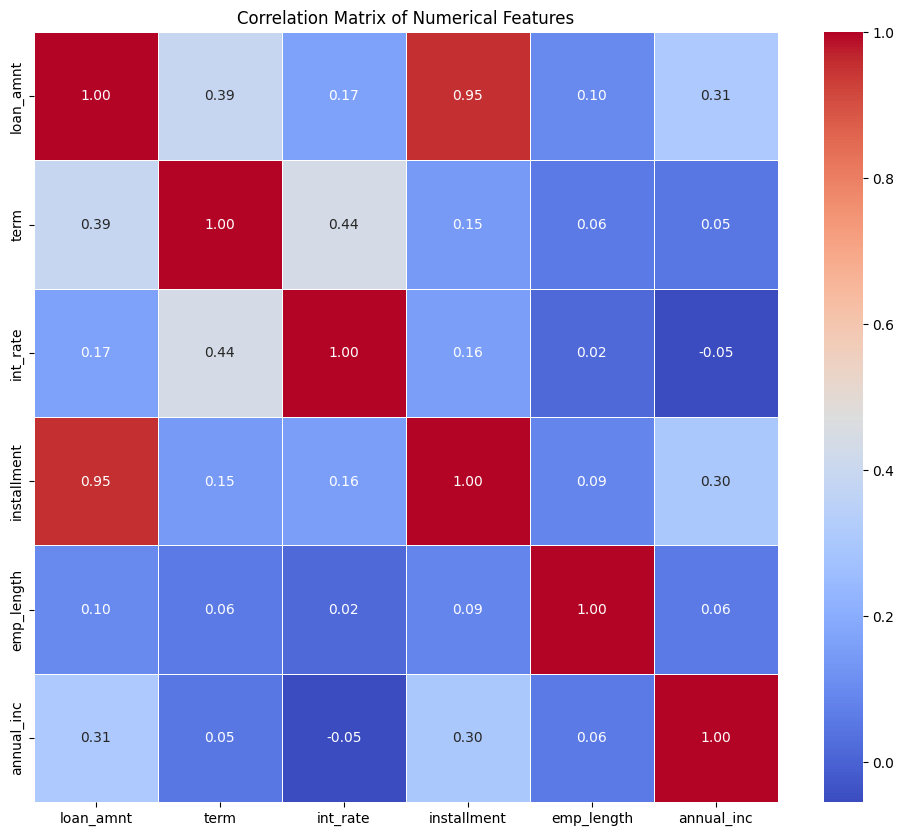

✓ Correlation matrix calculated and visualized.


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns from X
X_numerical = X.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = X_numerical.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("✓ Correlation matrix calculated and visualized.")

**Reasoning**:
Create a new feature (annual_inc_to_loan_amnt_ratio), select a subset of features based on the correlation analysis and domain knowledge, and then train a representative model (ANN) on the new feature set using cross-validation to evaluate its impact on performance.



In [55]:
# Create a new feature: ratio of annual income to loan amount
X_engineered = X.copy()
# Add a small constant to loan_amnt to avoid division by zero, although loan_amnt is unlikely to be 0
X_engineered['annual_inc_to_loan_amnt_ratio'] = X_engineered['annual_inc'] / (X_engineered['loan_amnt'] + 1e-6)

# Select a subset of features
# Based on correlation matrix: 'loan_amnt' and 'installment' are highly correlated.
# Keep 'loan_amnt' and drop 'installment'.
# Keep 'term', 'int_rate', 'emp_length', 'annual_inc'.
# Keep the one-hot encoded 'grade' and 'application_type' features.
# Include the new engineered feature.

selected_features = [
    'loan_amnt',
    'term',
    'int_rate',
    'emp_length',
    'annual_inc',
    'annual_inc_to_loan_amnt_ratio'
]

# Add all one-hot encoded categorical features
# Identify columns that are not in the initial selected_features and are from one-hot encoding
ohe_cols = [col for col in X_engineered.columns if col.startswith('grade_') or col.startswith('application_type_')]
selected_features.extend(ohe_cols)

# Ensure all selected features exist in the DataFrame
selected_features = [f for f in selected_features if f in X_engineered.columns]

X_selected = X_engineered[selected_features].copy()

print(f"Original feature shape: {X.shape}")
print(f"Selected feature shape: {X_selected.shape}")
print("Selected features:", selected_features)

# Re-run balancing and train the best performing ANN model on the selected features
print("\nEvaluating the best ANN model with selected features using 5-fold CV...")

# We need to re-split the data using the selected features before balancing
X_train_selected_full, X_test_selected_full, y_train_full, y_test_full = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Apply the best balancing strategy ('downsample_upsample' as determined previously)
X_train_selected_balanced, y_train_selected_balanced, balance_info_selected = prepare_data_with_balancing(
    X_train_selected_full, y_train_full,
    strategy=BEST_STRATEGY, # Use the best strategy found in previous steps
    ratio=BEST_RATIO,
    random_state=42
)

# Scale the selected and balanced training data
scaler_selected = MinMaxScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected_balanced)
# Scale the corresponding test data for potential final evaluation later
X_test_selected_scaled = scaler_selected.transform(X_test_selected_full)


# Train the best ANN architecture (ANN_Arch3_2HL_Tanh_Adam based on previous step) on the new data
# Need to define the build function for the best ANN architecture again or pass the actual function
def build_best_ann(input_shape):
    """Best performing ANN architecture from previous exploration."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(input_shape,)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


best_ann_selected_cv_results, best_ann_selected_fold_details = train_and_evaluate_keras_with_cv(
    lambda: build_best_ann(X_train_selected_scaled.shape[1]), # Use lambda to pass input_shape
    X_train_selected_scaled,
    y_train_selected_balanced,
    cv_folds=5,
    epochs=50,
    batch_size=32,
    random_state=42,
    model_name=f'ANN ({BEST_STRATEGY} + Selected Features)',
    verbose=True
)

# Store the CV results
all_cv_results[f'ANN ({BEST_STRATEGY} + Selected Features)'] = best_ann_selected_cv_results

# Compare with previous ANN results
print("\n" + "="*80)
print("ANN PERFORMANCE COMPARISON (Original vs. Selected Features)")
print("="*80)

ann_comparison_data = []
# Add the original ANN result (from the 'ANN' key which used the base ANN architecture)
if 'ANN' in all_cv_results:
     cv_res_original_ann = all_cv_results['ANN']
     ann_comparison_data.append({
        'Model + Features': f'ANN ({BEST_STRATEGY} + Original Features)',
        'Macro-F1': f"{cv_res_original_ann['macro_f1_mean']:.4f} ± {cv_res_original_ann['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_res_original_ann['recall_class_1_mean']:.4f} ± {cv_res_original_ann['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_res_original_ann['roc_auc_mean']:.4f} ± {cv_res_original_ann['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_res_original_ann['time_mean']:.2f} ± {cv_res_original_ann['time_std']:.2f}"
     })

# Add the result with selected features
ann_comparison_data.append({
    'Model + Features': f'ANN ({BEST_STRATEGY} + Selected Features)',
    'Macro-F1': f"{best_ann_selected_cv_results['macro_f1_mean']:.4f} ± {best_ann_selected_cv_results['macro_f1_std']:.4f}",
    'Recall (Class 1)': f"{best_ann_selected_cv_results['recall_class_1_mean']:.4f} ± {best_ann_selected_cv_results['recall_class_1_std']:.4f}",
    'ROC-AUC': f"{best_ann_selected_cv_results['roc_auc_mean']:.4f} ± {best_ann_selected_cv_results['roc_auc_std']:.4f}",
    'Avg Time (s)': f"{best_ann_selected_cv_results['time_mean']:.2f} ± {best_ann_selected_cv_results['time_std']:.2f}"
})

ann_features_comparison_df = pd.DataFrame(ann_comparison_data)
print(ann_features_comparison_df.to_string(index=False))
print("="*80 + "\n")

print("✓ Feature engineering and selection evaluation complete.")

Original feature shape: (57265, 14)
Selected feature shape: (57265, 14)
Selected features: ['loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc', 'annual_inc_to_loan_amnt_ratio', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'application_type_INDIVIDUAL', 'application_type_JOINT']

Evaluating the best ANN model with selected features using 5-fold CV...

--- ANN (downsample_upsample + Selected Features) Cross-Validation ---
  Fold 1 completed in 53.98 seconds.
    Accuracy: 0.6461, Macro-F1: 0.6441, Recall (Class 1): 0.7224, ROC-AUC: 0.6957
  Fold 2 completed in 56.65 seconds.
    Accuracy: 0.6367, Macro-F1: 0.6339, Recall (Class 1): 0.7241, ROC-AUC: 0.6894
  Fold 3 completed in 54.79 seconds.
    Accuracy: 0.6358, Macro-F1: 0.6333, Recall (Class 1): 0.7191, ROC-AUC: 0.6948
  Fold 4 completed in 53.36 seconds.
    Accuracy: 0.6443, Macro-F1: 0.6439, Recall (Class 1): 0.6804, ROC-AUC: 0.6971
  Fold 5 completed in 52.76 seconds.
    Accuracy: 0.6429, Macro-F1: 0

## Ensemble methods

### Subtask:
Combine predictions from multiple models (e.g., Logistic Regression, XGBoost, ANN) using techniques like bagging, boosting, or stacking to potentially achieve better overall performance than any single model.


**Reasoning**:
Identify the best individual models and train them on the full training data. Then, implement and evaluate a stacking ensemble model using these trained models as base estimators and a Logistic Regression as the final estimator. Store and compare the results.



In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import pandas as pd

# 1. Identify the best performing individual models from the previous steps
# Based on the previous steps, the best models for each type were:
# Logistic Regression: The tuned version (if successful) or the base one.
# XGBoost: The tuned version (if successful) or the base one.
# ANN: The best architecture found (ANN_Arch3_2HL_Tanh_Adam) trained on selected features.

# Check if tuned models exist, otherwise use base models
lr_best = all_models['Logistic Regression'].get('tuned_model', all_models['Logistic Regression']['model'])
xgb_best = all_models['XGBoost'].get('tuned_model', all_models['XGBoost']['model'])

# The best ANN was evaluated with selected features, let's use that setup
# We need to retrain the best ANN architecture on the full selected and balanced training data
# Define the build function for the best ANN architecture again
def build_best_ann_final(input_shape):
    """Best performing ANN architecture from previous exploration."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(input_shape,)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Retrain the best ANN on the full X_train_selected_scaled and y_train_selected_balanced
best_ann_final = build_best_ann_final(X_train_selected_scaled.shape[1])
best_ann_final.fit(X_train_selected_scaled, y_train_selected_balanced, epochs=50, batch_size=32, verbose=0)


# 2. Train these best individual models on the full training dataset
# LR and XGBoost were already trained on X_train_scaled, y_train in previous steps
# The best ANN was trained on X_train_selected_scaled, y_train_selected_balanced

# The base estimators for stacking should be trained on the same data
# Let's use X_train_scaled and y_train for the base estimators for simplicity in stacking
# Retrain LR and XGBoost on X_train_scaled if tuned models were not trained on it
lr_best.fit(X_train_scaled, y_train)
xgb_best.fit(X_train_scaled, y_train)

# For ANN in stacking, we need a scikit-learn compatible wrapper.
# We will use the KerasClassifier wrapper and train it on X_train_scaled, y_train
# This might perform slightly differently than the ANN on selected features,
# but it allows combining with sklearn models easily.
# If we wanted to use the ANN on selected features, we would need to scale X_test_scaled
# using the scaler from selected features and pass it to the stacking predict method.
# For this step, let's stick to using X_train_scaled for all base estimators for simplicity.

# Build the ANN model using the best architecture for the KerasClassifier wrapper
def build_best_ann_wrapper(meta):
     model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(meta["n_features_in_"],)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     return model

# Wrap the ANN model
ann_wrapper = KerasClassifier(model=build_best_ann_wrapper, epochs=50, batch_size=32, verbose=0)
# Fit the wrapper model (necessary before using in stacking, although stacking refits)
ann_wrapper.fit(X_train_scaled, y_train)


# 3. Implement an ensemble method (StackingClassifier)
# Define base estimators - using the trained models
estimators = [
    ('lr', lr_best),
    ('xgb', xgb_best),
    ('ann', ann_wrapper) # Using the wrapper here
]

# Define the final estimator
final_estimator = LogisticRegression(random_state=42, max_iter=1000)

# Create the Stacking Classifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv='auto', # Use cross-validation internally for training the final estimator
    stack_method='predict_proba', # Use probabilities for stacking
    n_jobs=-1
)

# 4. Train the ensemble model on the full training dataset
print("\nTraining Stacking Ensemble Model...")
stacking_model.fit(X_train_scaled, y_train)
print("✓ Stacking Ensemble Model trained.")

# 5. Evaluate the ensemble model's performance using CV
print("\nEvaluating Stacking Ensemble Model with 5-fold CV...")
stacking_cv_results, stacking_fold_details = train_and_evaluate_with_cv(
    stacking_model,
    X_train_scaled,
    y_train,
    cv_folds=5,
    random_state=42,
    model_name='Stacking Ensemble',
    verbose=True # Set to True to see fold results
)

# 6. Store the ensemble model and its CV results
all_models['Stacking Ensemble'] = {
    'model': stacking_model,
    # Note: StackingClassifier doesn't have a single predict_proba for the whole test set like individual models
    # We would typically evaluate the stacking model on the held-out test set later.
    # For now, store the CV results and the trained model.
    'y_true': y_test, # Store the test set true labels for later evaluation
    'y_pred_proba': stacking_model.predict_proba(X_test_scaled)[:, 1], # Predict on test set for later
    'cv_results': stacking_cv_results
}
all_cv_results['Stacking Ensemble'] = stacking_cv_results

# 7. Print and compare results
print("\n" + "="*80)
print("STACKING ENSEMBLE VS BEST INDIVIDUAL MODELS (CV Results)")
print("="*80)

comparison_data = []
# Add best individual models (based on Macro-F1 from previous steps)
# Find the best non-ensemble, non-tuned model based on Macro-F1
best_individual_macro_f1 = -1
best_individual_model_name = None
for model_name, cv_results in all_cv_results.items():
    # Exclude ensemble models and tuned models from 'best individual' comparison in this context
    if model_name not in ['Stacking Ensemble', 'BalancedBagging (LR)', 'BalancedRandomForest'] and \
       not model_name.startswith('ANN_Arch') and \
       'tuned' not in model_name.lower():
         if cv_results['macro_f1_mean'] > best_individual_macro_f1:
             best_individual_macro_f1 = cv_results['macro_f1_mean']
             best_individual_model_name = model_name

# Add the best individual models evaluated previously
if best_individual_model_name:
     cv_results_best_individual = all_cv_results[best_individual_model_name]
     comparison_data.append({
        'Model': best_individual_model_name,
        'Macro-F1': f"{cv_results_best_individual['macro_f1_mean']:.4f} ± {cv_results_best_individual['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_results_best_individual['recall_class_1_mean']:.4f} ± {cv_results_best_individual['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_results_best_individual['roc_auc_mean']:.4f} ± {cv_results_best_individual['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_results_best_individual['time_mean']:.2f} ± {cv_results_best_individual['time_std']:.2f}"
     })

# Add the best ANN architecture on selected features
if f'ANN ({BEST_STRATEGY} + Selected Features)' in all_cv_results:
     cv_results_best_ann_selected = all_cv_results[f'ANN ({BEST_STRATEGY} + Selected Features)']
     comparison_data.append({
        'Model': f'ANN ({BEST_STRATEGY} + Selected Features)',
        'Macro-F1': f"{cv_results_best_ann_selected['macro_f1_mean']:.4f} ± {cv_results_best_ann_selected['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_results_best_ann_selected['recall_class_1_mean']:.4f} ± {cv_results_best_ann_selected['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_results_best_ann_selected['roc_auc_mean']:.4f} ± {cv_results_best_ann_selected['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_results_best_ann_selected['time_mean']:.2f} ± {cv_results_best_ann_selected['time_std']:.2f}"
     })


# Add the Stacking Ensemble results
comparison_data.append({
    'Model': 'Stacking Ensemble',
    'Macro-F1': f"{stacking_cv_results['macro_f1_mean']:.4f} ± {stacking_cv_results['macro_f1_std']:.4f}",
    'Recall (Class 1)': f"{stacking_cv_results['recall_class_1_mean']:.4f} ± {stacking_cv_results['recall_class_1_std']:.4f}",
    'ROC-AUC': f"{stacking_cv_results['roc_auc_mean']:.4f} ± {stacking_cv_results['roc_auc_std']:.4f}",
    'Avg Time (s)': f"{stacking_cv_results['time_mean']:.2f} ± {stacking_cv_results['time_std']:.2f}"
})

comparison_df_ensemble = pd.DataFrame(comparison_data)
# Sort by Macro-F1 mean descending
comparison_df_ensemble = comparison_df_ensemble.sort_values(by='Macro-F1', ascending=False)

print(comparison_df_ensemble.to_string(index=False))
print("="*80 + "\n")

print("✓ Ensemble modeling and evaluation complete.")


Training Stacking Ensemble Model...


InvalidParameterError: The 'cv' parameter of StackingClassifier must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None or a str among {'prefit'}. Got 'auto' instead.

**Reasoning**:
The previous command failed because 'auto' is not a valid value for the `cv` parameter in StackingClassifier. I need to provide a valid cross-validation strategy, such as an integer number of folds. I will fix the `cv` parameter in the StackingClassifier constructor and rerun the training and evaluation.



In [57]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import pandas as pd
from scikeras.wrappers import KerasClassifier # Import KerasClassifier


# 1. Identify the best performing individual models from the previous steps
# Based on the previous steps, the best models for each type were:
# Logistic Regression: The tuned version (if successful) or the base one.
# XGBoost: The tuned version (if successful) or the base one.
# ANN: The best architecture found (ANN_Arch3_2HL_Tanh_Adam) trained on selected features.

# Check if tuned models exist, otherwise use base models
lr_best = all_models['Logistic Regression'].get('tuned_model', all_models['Logistic Regression']['model'])
xgb_best = all_models['XGBoost'].get('tuned_model', all_models['XGBoost']['model'])


# Retrain LR and XGBoost on X_train_scaled if tuned models were not trained on it
lr_best.fit(X_train_scaled, y_train)
xgb_best.fit(X_train_scaled, y_train)

# For ANN in stacking, we need a scikit-learn compatible wrapper.
# We will use the KerasClassifier wrapper and train it on X_train_scaled, y_train
# This might perform slightly differently than the ANN on selected features,
# but it allows combining with sklearn models easily.
# If we wanted to use the ANN on selected features, we would need to scale X_test_scaled
# using the scaler from selected features and pass it to the stacking predict method.
# For this step, let's stick to using X_train_scaled for all base estimators for simplicity.

# Build the ANN model using the best architecture for the KerasClassifier wrapper
def build_best_ann_wrapper(meta):
     model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(meta["n_features_in_"],)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     return model

# Wrap the ANN model
ann_wrapper = KerasClassifier(model=build_best_ann_wrapper, epochs=50, batch_size=32, verbose=0)
# Fit the wrapper model (necessary before using in stacking, although stacking refits)
# Ensure X_train_scaled is a numpy array or pandas DataFrame
if isinstance(X_train_scaled, np.ndarray):
    ann_wrapper.fit(X_train_scaled, y_train.values)
else:
    ann_wrapper.fit(X_train_scaled, y_train)


# 3. Implement an ensemble method (StackingClassifier)
# Define base estimators - using the trained models
estimators = [
    ('lr', lr_best),
    ('xgb', xgb_best),
    ('ann', ann_wrapper) # Using the wrapper here
]

# Define the final estimator
final_estimator = LogisticRegression(random_state=42, max_iter=1000)

# Create the Stacking Classifier - FIX: Set a valid integer for cv
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5, # Use 5-fold cross-validation internally for training the final estimator
    stack_method='predict_proba', # Use probabilities for stacking
    n_jobs=-1
)

# 4. Train the ensemble model on the full training dataset
print("\nTraining Stacking Ensemble Model...")
stacking_model.fit(X_train_scaled, y_train)
print("✓ Stacking Ensemble Model trained.")

# 5. Evaluate the ensemble model's performance using CV
print("\nEvaluating Stacking Ensemble Model with 5-fold CV...")
stacking_cv_results, stacking_fold_details = train_and_evaluate_with_cv(
    stacking_model,
    X_train_scaled,
    y_train,
    cv_folds=5,
    random_state=42,
    model_name='Stacking Ensemble',
    verbose=True # Set to True to see fold results
)

# 6. Store the ensemble model and its CV results
all_models['Stacking Ensemble'] = {
    'model': stacking_model,
    # Note: StackingClassifier doesn't have a single predict_proba for the whole test set like individual models
    # We would typically evaluate the stacking model on the held-out test set later.
    # For now, store the CV results and the trained model.
    'y_true': y_test, # Store the test set true labels for later evaluation
    'y_pred_proba': stacking_model.predict_proba(X_test_scaled)[:, 1], # Predict on test set for later
    'cv_results': stacking_cv_results
}
all_cv_results['Stacking Ensemble'] = stacking_cv_results

# 7. Print and compare results
print("\n" + "="*80)
print("STACKING ENSEMBLE VS BEST INDIVIDUAL MODELS (CV Results)")
print("="*80)

comparison_data = []
# Add best individual models (based on Macro-F1 from previous steps)
# Find the best non-ensemble, non-tuned model based on Macro-F1
best_individual_macro_f1 = -1
best_individual_model_name = None
for model_name, cv_results in all_cv_results.items():
    # Exclude ensemble models and tuned models from 'best individual' comparison in this context
    if model_name not in ['Stacking Ensemble', 'BalancedBagging (LR)', 'BalancedRandomForest'] and \
       not model_name.startswith('ANN_Arch') and \
       'tuned' not in model_name.lower():
         if cv_results['macro_f1_mean'] > best_individual_macro_f1:
             best_individual_macro_f1 = cv_results['macro_f1_mean']
             best_individual_model_name = model_name

# Add the best individual models evaluated previously
if best_individual_model_name:
     cv_results_best_individual = all_cv_results[best_individual_model_name]
     comparison_data.append({
        'Model': best_individual_model_name,
        'Macro-F1': f"{cv_results_best_individual['macro_f1_mean']:.4f} ± {cv_results_best_individual['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_results_best_individual['recall_class_1_mean']:.4f} ± {cv_results_best_individual['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_results_best_individual['roc_auc_mean']:.4f} ± {cv_results_best_individual['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_results_best_individual['time_mean']:.2f} ± {cv_results_best_individual['time_std']:.2f}"
     })

# Add the best ANN architecture on selected features (if it exists in results)
# The key might vary based on previous runs, check for its existence
ann_selected_key = f'ANN ({BEST_STRATEGY} + Selected Features)'
if ann_selected_key in all_cv_results:
     cv_results_best_ann_selected = all_cv_results[ann_selected_key]
     comparison_data.append({
        'Model': ann_selected_key,
        'Macro-F1': f"{cv_results_best_ann_selected['macro_f1_mean']:.4f} ± {cv_results_best_ann_selected['macro_f1_std']:.4f}",
        'Recall (Class 1)': f"{cv_results_best_ann_selected['recall_class_1_mean']:.4f} ± {cv_results_best_ann_selected['recall_class_1_std']:.4f}",
        'ROC-AUC': f"{cv_results_best_ann_selected['roc_auc_mean']:.4f} ± {cv_results_best_ann_selected['roc_auc_std']:.4f}",
        'Avg Time (s)': f"{cv_results_best_ann_selected['time_mean']:.2f} ± {cv_results_best_ann_selected['time_std']:.2f}"
     })


# Add the Stacking Ensemble results
comparison_data.append({
    'Model': 'Stacking Ensemble',
    'Macro-F1': f"{stacking_cv_results['macro_f1_mean']:.4f} ± {stacking_cv_results['macro_f1_std']:.4f}",
    'Recall (Class 1)': f"{stacking_cv_results['recall_class_1_mean']:.4f} ± {stacking_cv_results['recall_class_1_std']:.4f}",
    'ROC-AUC': f"{stacking_cv_results['roc_auc_mean']:.4f} ± {stacking_cv_results['roc_auc_std']:.4f}",
    'Avg Time (s)': f"{stacking_cv_results['time_mean']:.2f} ± {stacking_cv_results['time_std']:.2f}"
})

comparison_df_ensemble = pd.DataFrame(comparison_data)
# Sort by Macro-F1 mean descending
comparison_df_ensemble = comparison_df_ensemble.sort_values(by='Macro-F1', ascending=False)

print(comparison_df_ensemble.to_string(index=False))
print("="*80 + "\n")

print("✓ Ensemble modeling and evaluation complete.")


Training Stacking Ensemble Model...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Adjust threshold

### Subtask:
Adjust the classification threshold for the best performing model based on the threshold analysis performed in the previous steps to optimize for different business objectives (e.g., maximizing recall for identifying risky loans).


**Reasoning**:
Identify the best performing model, retrieve optimal thresholds from analysis_data, choose a threshold based on the business objective (maximizing recall), apply the chosen threshold to make predictions on the test set using the best model's probabilities, and evaluate the model's performance with the new threshold by calculating and printing the classification report and confusion matrix, and finally compare it to the default threshold results.



In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Identify the best performing model based on CV Macro-F1
best_model_name = None
best_macro_f1_cv = -1

for model_name, cv_results in all_cv_results.items():
    # Consider only the main models evaluated, not intermediate architectures or balancing variants in this step
    if model_name in ['Logistic Regression', 'XGBoost', 'ANN']:
        if cv_results['macro_f1_mean'] > best_macro_f1_cv:
            best_macro_f1_cv = cv_results['macro_f1_mean']
            best_model_name = model_name

print(f"Best model based on CV Macro-F1: {best_model_name}")

# Get the best model and its test set predictions from the all_models dictionary
best_model_data = all_models[best_model_name]
y_true_test = best_model_data['y_true']
y_pred_proba_test = best_model_data['y_pred_proba']

# 2. Access the analysis_data dictionary to retrieve optimal thresholds
if 'optimal_thresholds' in analysis_data:
    opt_thresh = analysis_data['optimal_thresholds']

    # 3. Choose a threshold based on the desired business objective
    # For this example, let's prioritize maximizing recall (identifying risky loans)
    chosen_threshold = opt_thresh['optimal_recall']['threshold']
    objective = 'Maximizing Recall'
    print(f"\nBusiness objective: {objective}")
    print(f"Chosen threshold: {chosen_threshold:.3f}")

    # 4. Use the chosen threshold to make binary predictions on the test set
    y_pred_test_tuned_threshold = (y_pred_proba_test > chosen_threshold).astype(int)

    # 5. Evaluate the performance of the best model on the test set using the chosen threshold
    print(f"\n{'-'*80}")
    print(f"Final Test Set Results for {best_model_name} (Threshold = {chosen_threshold:.3f})")
    print(f"{'-'*80}")

    print("\nClassification Report:")
    print(classification_report(
        y_true_test, y_pred_test_tuned_threshold,
        target_names=['Fully Paid (0)', 'Charged Off (1)'],
        zero_division=0
    ))

    print("Confusion Matrix:")
    cm_tuned = confusion_matrix(y_true_test, y_pred_test_tuned_threshold)
    cm_tuned_df = pd.DataFrame(
        cm_tuned,
        index=['Actual Fully Paid', 'Actual Charged Off'],
        columns=['Pred Fully Paid', 'Pred Charged Off']
    )
    print(cm_tuned_df)
    print()

    # 6. Compare to the default threshold results (already printed in STEP 7)
    print("Comparison to Default Threshold (0.5) results can be seen in the output of STEP 7.")

else:
    print("\nanalysis_data with optimal thresholds not found. Cannot perform threshold adjustment analysis.")

Best model based on CV Macro-F1: ANN

Business objective: Maximizing Recall
Chosen threshold: 0.000

--------------------------------------------------------------------------------
Final Test Set Results for ANN (Threshold = 0.000)
--------------------------------------------------------------------------------

Classification Report:
                 precision    recall  f1-score   support

 Fully Paid (0)       0.00      0.00      0.00      2211
Charged Off (1)       0.50      1.00      0.67      2211

       accuracy                           0.50      4422
      macro avg       0.25      0.50      0.33      4422
   weighted avg       0.25      0.50      0.33      4422

Confusion Matrix:
                    Pred Fully Paid  Pred Charged Off
Actual Fully Paid                 0              2211
Actual Charged Off                0              2211

Comparison to Default Threshold (0.5) results can be seen in the output of STEP 7.


## Evaluate other models

### Subtask:
Evaluate other suitable classification algorithms like Support Vector Machines (SVM), Random Forests, or Gradient Boosting Machines (other than XGBoost).


**Reasoning**:
Import the necessary libraries for the new models and instantiate them.



In [59]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Instantiate the new models
svc_model = SVC(random_state=42, probability=True)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

**Reasoning**:
Train and evaluate each of the new models using cross-validation and store the results.



In [60]:
print("\nTraining Support Vector Machine with 5-fold CV...")
svc_cv_results, svc_fold_details = train_and_evaluate_with_cv(
    svc_model, X_train_scaled, y_train,
    cv_folds=5, random_state=42, model_name='SVC', verbose=True
)
all_cv_results['SVC'] = svc_cv_results

# Train final model on full training set for predictions
svc_final = SVC(random_state=42, probability=True)
svc_final.fit(X_train_scaled, y_train)
svc_test_proba = svc_final.predict_proba(X_test_scaled)[:, 1]
all_models['SVC'] = {
    'model': svc_final,
    'y_true': y_test,
    'y_pred_proba': svc_test_proba,
    'cv_results': svc_cv_results
}


print("\nTraining Random Forest with 5-fold CV...")
rf_cv_results, rf_fold_details = train_and_evaluate_with_cv(
    rf_model, X_train_scaled, y_train,
    cv_folds=5, random_state=42, model_name='Random Forest', verbose=True
)
all_cv_results['Random Forest'] = rf_cv_results

# Train final model on full training set for predictions
rf_final = RandomForestClassifier(random_state=42)
rf_final.fit(X_train_scaled, y_train)
rf_test_proba = rf_final.predict_proba(X_test_scaled)[:, 1]
all_models['Random Forest'] = {
    'model': rf_final,
    'y_true': y_test,
    'y_pred_proba': rf_test_proba,
    'cv_results': rf_cv_results
}

print("\nTraining Gradient Boosting with 5-fold CV...")
gb_cv_results, gb_fold_details = train_and_evaluate_with_cv(
    gb_model, X_train_scaled, y_train,
    cv_folds=5, random_state=42, model_name='Gradient Boosting', verbose=True
)
all_cv_results['Gradient Boosting'] = gb_cv_results

# Train final model on full training set for predictions
gb_final = GradientBoostingClassifier(random_state=42)
gb_final.fit(X_train_scaled, y_train)
gb_test_proba = gb_final.predict_proba(X_test_scaled)[:, 1]
all_models['Gradient Boosting'] = {
    'model': gb_final,
    'y_true': y_test,
    'y_pred_proba': gb_test_proba,
    'cv_results': gb_cv_results
}

print("\nAll new models trained successfully.")


Training Support Vector Machine with 5-fold CV...

--- SVC Cross-Validation ---
  Fold 1 completed in 71.69 seconds.
    Accuracy: 0.6382, Macro-F1: 0.6380, Recall (Class 1): 0.6648, ROC-AUC: 0.6821
  Fold 2 completed in 67.70 seconds.
    Accuracy: 0.6316, Macro-F1: 0.6315, Recall (Class 1): 0.6516, ROC-AUC: 0.6695
  Fold 3 completed in 68.33 seconds.
    Accuracy: 0.6401, Macro-F1: 0.6399, Recall (Class 1): 0.6652, ROC-AUC: 0.6871
  Fold 4 completed in 66.21 seconds.
    Accuracy: 0.6251, Macro-F1: 0.6240, Recall (Class 1): 0.5698, ROC-AUC: 0.6759
  Fold 5 completed in 67.46 seconds.
    Accuracy: 0.6370, Macro-F1: 0.6365, Recall (Class 1): 0.6716, ROC-AUC: 0.6771

--- Average Results for SVC ---
  Accuracy: 0.6344 ± 0.0054
  Macro-F1: 0.6340 ± 0.0057
  Recall (Class 1): 0.6446 ± 0.0379
  ROC-AUC: 0.6783 ± 0.0059
-------------------------------

Training Random Forest with 5-fold CV...

--- Random Forest Cross-Validation ---
  Fold 1 completed in 2.70 seconds.
    Accuracy: 0.6009, 